#### **Model 1**
# **Machine Learning**

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
!pip install Augmentor
!pip install scikit-optimize
!pip install bayesian_optimization

In [32]:
from google.colab import files
uploaded = files.upload()

# Use the following code to uploade necessary modules
!ls

drive  EnvModule.py  __pycache__  sample_data


In [33]:
# Import Modules:
import EnvModule
from EnvModule import RunModel, MLModelSelector, METHODS_ACTIONS, ALGORITHM_METHODS


# Import Libraries:
import logging
import random
import time
import numpy as np
import itertools
from bayes_opt.util import UtilityFunction
from skopt.space import Categorical
from skopt import BayesSearchCV
from skopt.space import Real
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.src.backend import random_bernoulli
import networkx as nx
import matplotlib.pyplot as plt

from itertools import combinations
from functools import partial
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error



# Import datasets:
from sklearn import datasets

In [34]:
# Define global variables
bestFEMethods = {}

### **MLAgent Model**

In [35]:
class MLAgent:
    def __init__(self, problem_type, data, labels):
        self.problem_type = problem_type
        self.data = data
        self.labels = labels
        self.model_selector = MLModelSelector(problem_type=problem_type)
        self.algorithm = self.select_algorithm()
        self.model = self._initialize_model()
        self.feature_methods = self.select_feature_engineering_methods(self.algorithm)
        self.learning_history = {}  # Stores the history of the learning process
        self.best_combinations = {}  # Stores combinations with accuracy >= 90%
        self.history_over_epoch = {}

        # Initialize a logger
        self.logger = logging.getLogger(__name__)
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    def select_algorithm(self):
        # Use the MLModelSelector instance to select the algorithm.
        algorithm = self.model_selector.algorithm_selector()
        print("\n\nSelected algorithm:", algorithm, end="\n\n")
        return algorithm

    def _initialize_model(self):
        # Create a RunModel instance
        runner = RunModel(selected_algorithm=self.algorithm)
        self.model = runner.algorithm_processor(self.data)
        return self.model

    def select_feature_engineering_methods(self, algorithm):
        # Use the MLModelSelector instance to select the feature engineering methods.
        methods_dict = ALGORITHM_METHODS.get(algorithm)
        # If no methods are defined for the algorithm, raise an error.
        if not methods_dict:
            raise ValueError(f"No feature engineering methods defined for algorithm: {algorithm}")
        feature_methods = list(methods_dict.keys())
        self.feature_methods = feature_methods

        return feature_methods


    def apply_feature_engineering(self, dataTrain, dataTest, feature_methods, feature_combinations):
        """
        Apply the list of feature engineering methods to the data.
        :param data: The dataset to process.
        :param feature_methods: A list of feature engineering methods to apply.
        :param random_combinations: A list of selected feature engineering methods from random combinations.
        :return: The processed dataset.
        """
        print("shape of the input data is: ", dataTrain.shape)
        self.logger.info("Starting feature engineering process...")
        processed_data_trainset = []  # To avoid changing the original data
        processed_data_testset = []

        # Import the correct configuration
        print(f"Random combinations ({len(feature_combinations)}) :  {feature_combinations}")
        #print(len(random_combinations))
        cc = 1
        for feature_combination in feature_combinations:
            print(f"========================== Random combination {cc}:{feature_combination} ==========================")
            cc += 1
            data2processTest = dataTest.copy()
            data2processTrain = dataTrain.copy()
            for method in feature_methods:
                #print("method: ", method)
                print("Shape after feature engineering - Train:", data2processTrain.shape, "Test:", data2processTest.shape)
                # Check if the method is in the list of random combinations
                if method in feature_combination:
                    self.logger.info(f"Applying feature engineering for method: {method}")
                    method_func = METHODS_ACTIONS.get(method)
                    if method_func:
                        # Apply the function. This assumes that your method functions are designed
                        # to process the data and return the transformed data.
                        try:
                            data2test = method_func(data2processTest)
                            data2train = method_func(data2processTrain)
                            print("Shape of the data now is: ", data2train.shape)

                            # Check for feature consistency
                            if data2train.shape[1] != data2test.shape[1]:
                                raise ValueError(f"Inconsistent feature count: train {data2train.shape[1]} vs test {data2test.shape[1]}")

                            # Update the data to process
                            data2processTest = data2test.copy()
                            data2processTrain = data2train.copy()
                        except Exception as e:
                            self.logger.error(f"Method {method} failed: {e}")

                    else:
                        self.logger.error(f"Method {method} not recognized or not implemented.")

            processed_data_testset.append(data2processTest)
            processed_data_trainset.append(data2processTrain)

        print("=================================================================================================================================")
        for i, proc_data in enumerate(processed_data_trainset):
            print(f"Data processed after applying combination number {i+1}, shape is {proc_data.shape}")

        self.logger.info("Feature engineering completed.")

        return processed_data_trainset, processed_data_testset

    # Evaluate the model using cross validation
    def evaluate_model_cross_val(self, model, data, labels, num_folds=5):
        # Ensure that the data and labels are in the correct format
        if data.ndim == 1:
            data = data.reshape(-1, 1)

        scores = cross_val_score(model, data, labels, cv=num_folds)
        return np.mean(scores)

    def update_learning_history(self, combination, reward):
        """
        Update the learning history with the combination and reward.
        """
        combination_key = tuple(combination)
        if combination_key in self.learning_history:
            old_reward = self.learning_history[combination_key]
            self.learning_history[combination_key] = (old_reward + reward) / 2
        else:
            self.learning_history[combination_key] = reward

    def run(self, epochs=10):
        # Split the data into training and testing sets
        dataTrain, dataTest, labelsTrain, labelsTest = train_test_split(self.data, self.labels, test_size=0.2, random_state=42)

        model_num = 0
        for epoch in range(epochs):
            # Use get_informed_combinations to select feature combinations
            if epoch == 0:
                # In the first epoch, use random combinations to explore
                feature_combinations = self.get_feature_combination()
            else:
                # In subsequent epochs, use informed combinations based on learning history
                feature_combinations = self.get_informed_combinations(self.algorithm)

            processed_data_trainset, processed_data_testset = self.apply_feature_engineering(dataTrain, dataTest, self.feature_methods, feature_combinations)


            for combination, (processed_data_train, processed_data_test) in enumerate(zip(processed_data_trainset, processed_data_testset)):
                print("Training start")
                if isinstance(self.model, tf.keras.Model):
                    local_model =  RunModel(selected_algorithm=self.algorithm).algorithm_processor(processed_data_train)
                    processed_data_train = processed_data_train.reshape(processed_data_train.shape[0], processed_data_train.shape[1], 1)
                    processed_data_test = processed_data_test.reshape(processed_data_test.shape[0], processed_data_test.shape[1], 1)
                    local_model.fit(processed_data_train, labelsTrain, epochs = 10)
                    evaluation = local_model.evaluate(processed_data_test, labelsTest, verbose=0)  # assuming model.evaluate() returns loss and accuracy
                    accuracy = evaluation[1]*100  # assuming accuracy is the second item returned
                #self.model = self.train_model(self.algorithm, processed_data_train, labelsTrain, epochs)

                else:
                    self.model = self.model.fit(processed_data_train, labelsTrain)
                    #accuracy = self.evaluate_model_cross_val(self.model, processed_data_train, labelsTrain, num_folds=5) * 100
                    accuracy = self.evaluate_model_cross_val(self.model, np.concatenate([processed_data_train, processed_data_test]), np.concatenate([labelsTrain, labelsTest]), num_folds=5) * 100

                # Print the results
                model_num += 1
                print(f"Epoch {epoch+1}, Model # {model_num}, accuracy = {accuracy:.4f}, Combination {feature_combinations[combination]}")

                # Update the learning history
                self.update_learning_history(feature_combinations[combination], accuracy)

                if accuracy >= 80.0:
                    combination_key = tuple(map(tuple, feature_combinations[combination]))  # Convert the combination to a tuple
                    self.best_combinations[combination_key] = accuracy
                    # Update best feature methods count
                    for method in feature_combinations[combination]:
                        key = (self.algorithm, method)
                        bestFEMethods[key] = bestFEMethods.get(key, 0) + 1

            self.history_over_epoch[epoch] = self.learning_history

        return self.get_best_combination()

    def get_feature_combination(self):
        # Set seed for reproducibility
        random.seed(42)
        # Get the list of feature engineering methods for the selected algorithm.
        methods = self.feature_methods
        # Uncomment the code below to generate all possible combinations with a maximum of 3 methods
        all_combinations = []
        for r in range(1, min(4, len(methods) + 2)):  # r is the size of the combinations
            all_combinations.extend(combinations(methods, r))

        # Ensure that all_combinations is a list of lists
        all_combinations = [list(comb) for comb in all_combinations]

        print(f"Total combination {len(all_combinations)}")
        min_number_of_random_combination = 10
        # Select random combinations.
        random_combinations = all_combinations
        #random_combinations = random.sample(all_combinations, min(min_number_of_random_combination, len(all_combinations)))
        # Set as instance variable
        self.random_combinations = random_combinations

        return random_combinations

    def get_informed_combinations(self, algorithm):
        # Set random seed
        random.seed(42)
        # Get the list of feature engineering methods for the selected algorithm.
        epsilon = 0.1  # Exploration rate
        if random.random() < epsilon or not self.learning_history:
            # If exploring or if there's no learning history, get random combinations
            return self.random_combinations
        else:
            # Exploit the best combinations from the learning history
            best_combinations = sorted(self.learning_history.items(), key=lambda x: x[1], reverse=True)
            # Select the top 3 combinations based on performance
            informed_combinations = [comb[0] for comb in best_combinations[:3]]
            self.informed_combinations = informed_combinations

            return informed_combinations

    def get_best_combination(self):
        if not self.best_combinations:
            print("No combinations achieved the desired accuracy.")
            return None
        return max(self.best_combinations, key=self.best_combinations.get)

    def print_top_model_combinations(self, top_n=10):
        print("Best Tob Combinations 10")
        top_combinations = sorted(self.best_combinations.items(), key=lambda item: item[1], reverse=True)[:top_n]
        for i, (combination, accuracy) in enumerate(top_combinations, 1):
            # Concatenate the characters in each method name
            formatted_methods = []
            for method_tuple in combination:
                method_name = ''.join(method_tuple)
                formatted_methods.append(method_name)

            formatted_method_names = ', '.join(formatted_methods)
            print(f"Combination {i}: {formatted_method_names} - Accuracy: {accuracy:.2f}%")


def print_best_feature_methods(bestFEMethods):
    print("Best feature methods (Based on Importance):")
    for key, value in sorted(bestFEMethods.items(), key=lambda x: x[1], reverse=True):
        print(f"{key}: {value}")

## **MLAgent Visiualization Code**

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Learning History Over Epochs
def plot_learning_history(agent_history, agent_history_values , c = 'b'):
    epochs = range(1, len(agent_history) + 1)
    accuracies = list(agent_history_values)

    plt.figure(figsize=(15, 8))
    plt.plot(epochs, accuracies, marker='o', linestyle='-', color =  c)
    plt.title('Learning History of different combination\n', fontweight='bold')
    plt.xlabel('Learning History')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
#plot_learning_history(agent)
#plot_learning_history(agent.learning_history, agent.learning_history.values())
#print("\n\n")
#print("----------------------------------------------------------------------------------------------------------")

# Best Feature Engineering Methods
def plot_best_feature_methods(bestFEMethods):
    methods = [f'{algorithm}: {method}' for algorithm, method in bestFEMethods.keys()]
    counts = list(bestFEMethods.values())
    sorted_indices = sorted(range(len(counts)), key=lambda i: counts[i], reverse=True)
    sorted_methods = [methods[i] for i in sorted_indices]
    sorted_counts = [counts[i] for i in sorted_indices]
    colors = sns.color_palette("hsv", len(sorted_methods))
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(sorted_methods)), sorted_counts, color=colors, tick_label=sorted_methods)
    plt.xlabel('Feature Engineering Methods')
    plt.ylabel('Count')
    plt.title('Best Feature Engineering Methods (Based on importance)\n', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.show()
#plot_best_feature_methods(bestFEMethods)
#print("\n\n")
#print("----------------------------------------------------------------------------------------------------------")

# Top 10 Best Evaluated Model Combinations
def plot_combination_accuracies(agent):
    sorted_combinations = sorted(agent.best_combinations.items(), key=lambda x: x[1], reverse=True)[:10]
    combinations = [f'Combination {i+1}' for i in range(len(sorted_combinations))]
    accuracies = [acc for _, acc in sorted_combinations]
    colors = plt.cm.viridis(np.linspace(0, 1, len(combinations)))
    plt.figure(figsize=(12, 6))
    bars = plt.bar(combinations, accuracies, color=colors)
    plt.xlabel('Model Combinations')
    plt.ylabel('Accuracy %')
    plt.title('Top 10 Best Evaluated Model Combinations\n', fontweight='bold')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 2), ha='center', va='bottom')
    plt.xticks(rotation=45)
    plt.show()
#plot_combination_accuracies(agent)

## Prediction problem (decision tree) on IRIS dataset

In [37]:
# Load the dataset
iris = datasets.load_iris()
data, labels = iris.data, iris.target

min_number_of_random_combination = 10
PROBLEM = "Prediction(multi-outcome)"

# Assuming you have already created and run the agent
agent = MLAgent(problem_type=PROBLEM, data=data, labels=labels)
agent.run(epochs=1)



Selected algorithm: decision_tree

Total combination 175
shape of the input data is:  (120, 4)
Random combinations (175) :  [['variance_threshold_selector'], ['principal_component_analysis'], ['kernel_pca'], ['independent_component_analysis'], ['non_negative_matrix_factorization'], ['singular_value_decomposition'], ['feature_agglomeration'], ['StandardScaler'], ['Binning'], ['PolynomialFeature-Interaction'], ['variance_threshold_selector', 'principal_component_analysis'], ['variance_threshold_selector', 'kernel_pca'], ['variance_threshold_selector', 'independent_component_analysis'], ['variance_threshold_selector', 'non_negative_matrix_factorization'], ['variance_threshold_selector', 'singular_value_decomposition'], ['variance_threshold_selector', 'feature_agglomeration'], ['variance_threshold_selector', 'StandardScaler'], ['variance_threshold_selector', 'Binning'], ['variance_threshold_selector', 'PolynomialFeature-Interaction'], ['principal_component_analysis', 'kernel_pca'], ['pri

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 15:['variance_threshold_selector', 'singular_value_decomposition'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 29:['kernel_pca', 'non_negative_matrix_factorization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30,

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWa

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 37:['independent_component_analysis', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Te

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whi

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 44:['non_negative_matrix_factorization', 'Binning'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 65:['variance_threshold_selector', 'kernel_pca', 'non_negative_matrix_factorization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (1

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWa

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 4)
========================== Random combination 71:['variance_threshold_selector', 'independent_component_analysis', 'non_negative_matrix_factorization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of 

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whi

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 78:['variance_threshold_selector', 'non_negative_matrix_factorization', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120,

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWa

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 100:['principal_component_analysis', 'independent_component_analysis', 'singular_value_decomposition'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Startin

 (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 123:['kernel_pca', 'independent_component_analysis', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 127:['kernel_pca', 'non_negative_matrix_factorization', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 128:['kernel_pca', 'non_negative_matrix_factorization', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 4)
========================== Random combination 131:['kernel_pca', 'singular_value_decomposition', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Sha

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maxim

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 143:['independent_component_analysis', 'non_negative_matrix_factorization', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWa

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 149:['independent_component_analysis', 'singular_value_decomposition', 'PolynomialFeature-Interaction'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whi

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 4)
========================== Random combination 156:['non_negative_matrix_factorization', 'singular_value_decomposition', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the dat

(('P',
  'o',
  'l',
  'y',
  'n',
  'o',
  'm',
  'i',
  'a',
  'l',
  'F',
  'e',
  'a',
  't',
  'u',
  'r',
  'e',
  '-',
  'I',
  'n',
  't',
  'e',
  'r',
  'a',
  'c',
  't',
  'i',
  'o',
  'n'),)

In [38]:
agent.print_top_model_combinations(top_n=10)
print("=================================================================================================================================")
print_best_feature_methods(bestFEMethods)

Best Tob Combinations 10
Combination 1: PolynomialFeature-Interaction - Accuracy: 96.00%
Combination 2: variance_threshold_selector, PolynomialFeature-Interaction - Accuracy: 96.00%
Combination 3: non_negative_matrix_factorization, singular_value_decomposition - Accuracy: 96.00%
Combination 4: variance_threshold_selector, non_negative_matrix_factorization, singular_value_decomposition - Accuracy: 96.00%
Combination 5: singular_value_decomposition - Accuracy: 95.33%
Combination 6: variance_threshold_selector, singular_value_decomposition - Accuracy: 95.33%
Combination 7: singular_value_decomposition, feature_agglomeration - Accuracy: 95.33%
Combination 8: StandardScaler, PolynomialFeature-Interaction - Accuracy: 95.33%
Combination 9: variance_threshold_selector, singular_value_decomposition, feature_agglomeration - Accuracy: 95.33%
Combination 10: variance_threshold_selector, StandardScaler, PolynomialFeature-Interaction - Accuracy: 95.33%
Best feature methods (Based on Importance):
('d

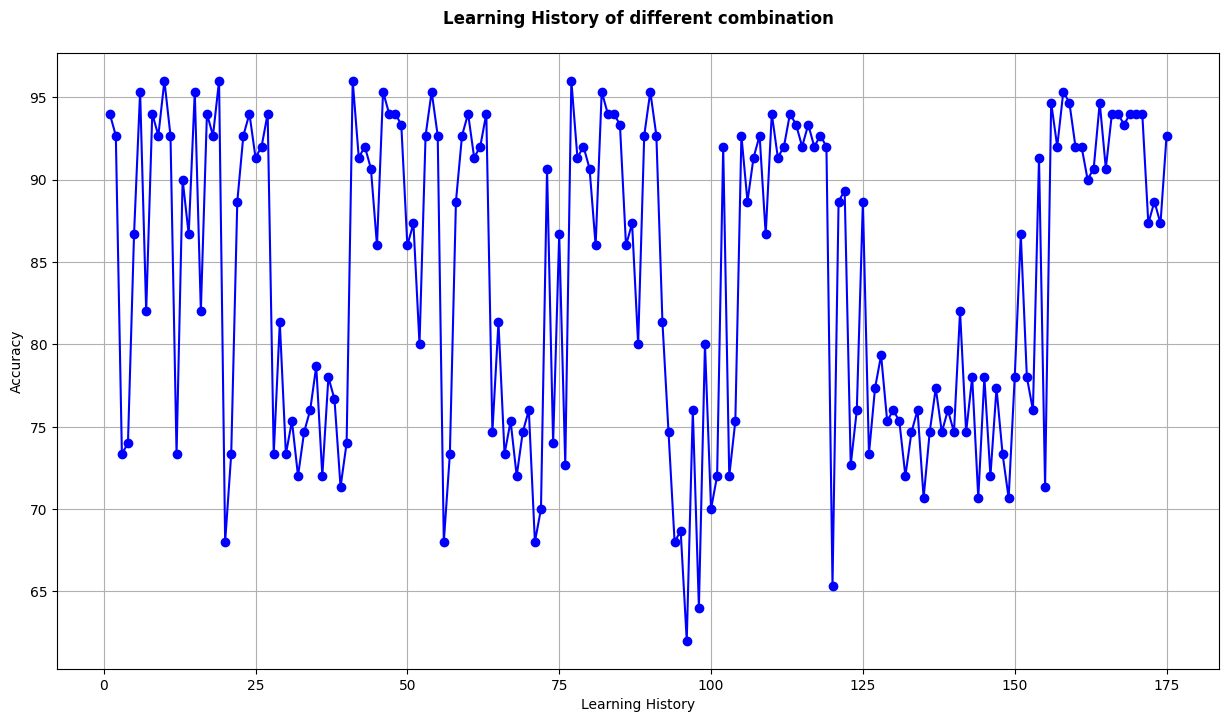




----------------------------------------------------------------------------------------------------------


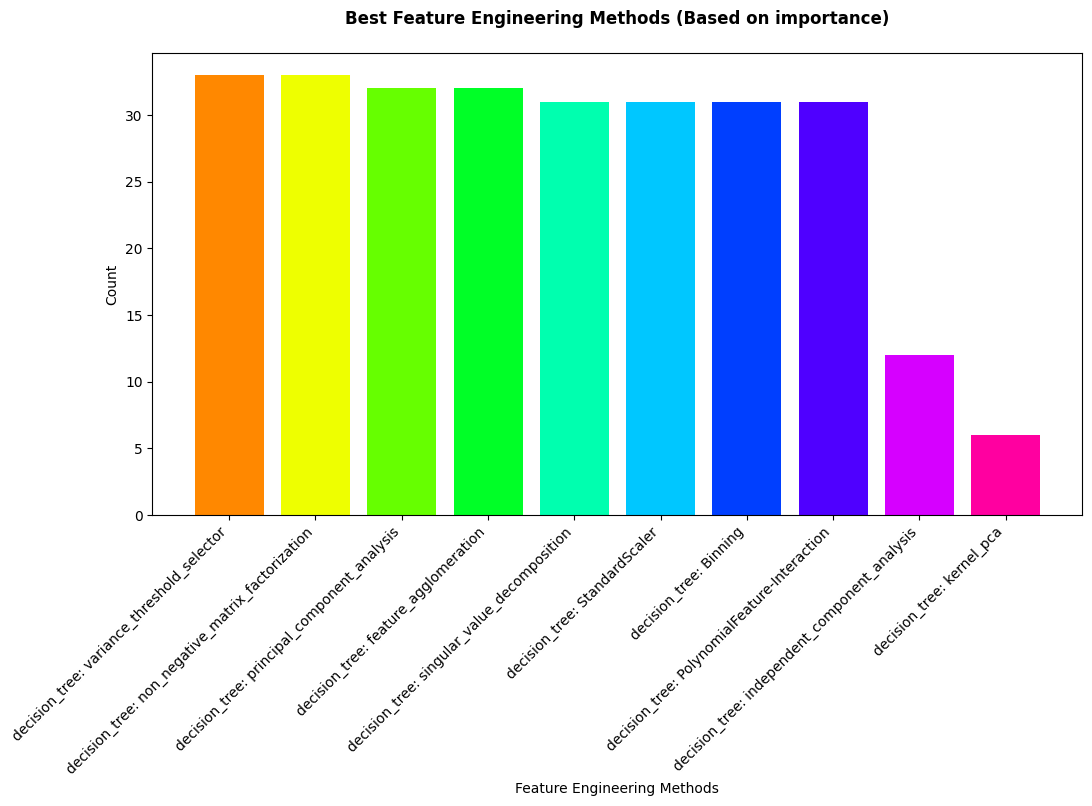




----------------------------------------------------------------------------------------------------------


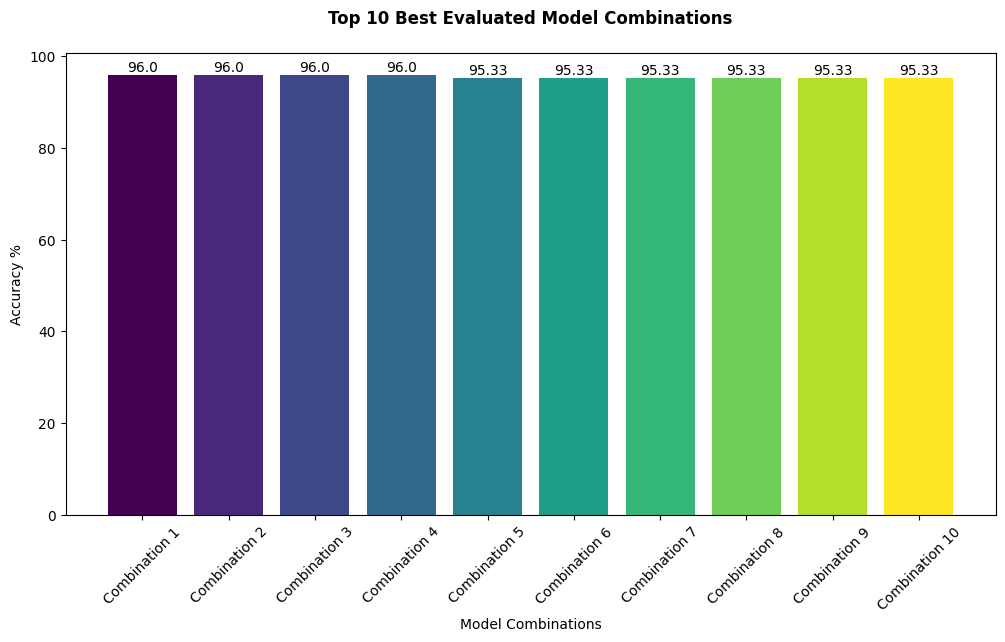

In [39]:
plot_learning_history(agent.learning_history, agent.learning_history.values())
print("\n\n")
print("----------------------------------------------------------------------------------------------------------")

plot_best_feature_methods(bestFEMethods)
print("\n\n")
print("----------------------------------------------------------------------------------------------------------")


plot_combination_accuracies(agent)

In [40]:
print("Learning history per epoch:")
num_epochs = 10
#for epoch in range(num_epochs):


for history_key, hist_value in agent.history_over_epoch.items():
  print(f"Epoch {history_key +1}:")

  #plot_learning_history(hist_value, hist_value.values(),'r')
  for combo, reward in hist_value.items():
    print(f"- {combo}: {reward}")

Learning history per epoch:
Epoch 1:
- ('variance_threshold_selector',): 94.0
- ('principal_component_analysis',): 92.66666666666666
- ('kernel_pca',): 73.33333333333334
- ('independent_component_analysis',): 74.0
- ('non_negative_matrix_factorization',): 86.66666666666666
- ('singular_value_decomposition',): 95.33333333333334
- ('feature_agglomeration',): 82.0
- ('StandardScaler',): 94.0
- ('Binning',): 92.66666666666667
- ('PolynomialFeature-Interaction',): 96.0
- ('variance_threshold_selector', 'principal_component_analysis'): 92.66666666666666
- ('variance_threshold_selector', 'kernel_pca'): 73.33333333333334
- ('variance_threshold_selector', 'independent_component_analysis'): 90.0
- ('variance_threshold_selector', 'non_negative_matrix_factorization'): 86.66666666666666
- ('variance_threshold_selector', 'singular_value_decomposition'): 95.33333333333334
- ('variance_threshold_selector', 'feature_agglomeration'): 82.0
- ('variance_threshold_selector', 'StandardScaler'): 94.0
- ('var

Learning history per epoch:
0


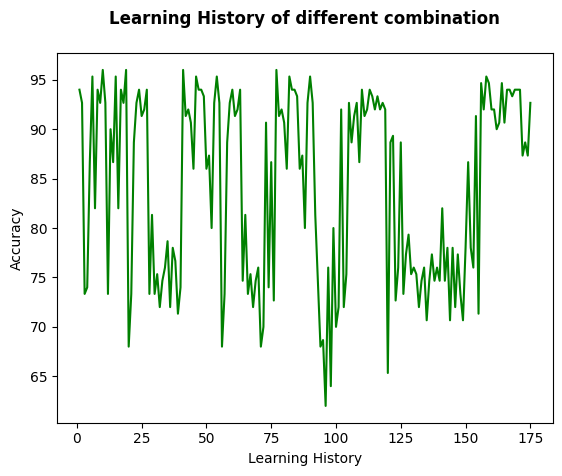

In [41]:
#TODO: Remove this cell

print("Learning history per epoch:")
num_epochs = 3
#for epoch in range(num_epochs):

import matplotlib.pyplot as plt

for history_key, hist_value in agent.history_over_epoch.items():

  if history_key >= num_epochs:
    break
  print(history_key)
  epochs = range(1, len(hist_value) + 1)
  accuracies = list(hist_value.values())
  if history_key==0:
    c= 'g'
  if history_key==1:
    c= 'b'
  if history_key==2:
    c= 'r'

  #plt.figure(figsize=(15, 8))
  plt.plot(epochs, accuracies, linestyle='-', color = c)
  plt.title('Learning History of different combination\n', fontweight='bold')
  plt.xlabel('Learning History')
  plt.ylabel('Accuracy')
  #plot_learning_history(hist_value, hist_value.values(),'r')

plt.show()


## Prediction problem (Using LogisticRegression model) on heart disease dataset downloaded from kaggle

In [42]:
# reading csv data,
# preprocessing (if required, convert any string values to int, filling the empty values or removing them)
# convert dataframe into array, as arrays are the required paramter.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/drive/MyDrive/FE project brayan/heart.csv') #Read the dataset
df = df.dropna()

#df.describe()

labels = df['target']
df = df.drop('target', axis=1)
data = df.to_numpy()
labels = labels.to_numpy()


min_number_of_random_combination = 10
PROBLEM = "Prediction(true/fales)"

# Assuming you have already created and run the agent
agent = MLAgent(problem_type=PROBLEM, data=data, labels=labels)
agent.run(epochs=1)

ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'




Selected algorithm: logistic_rm

Total combination 575
shape of the input data is:  (820, 13)
Random combinations (575) :  [['variance_threshold_selector'], ['anova_f_test_selector'], ['lasso_regularization_selector'], ['principal_component_analysis'], ['kernel_pca'], ['independent_component_analysis'], ['non_negative_matrix_factorization'], ['singular_value_decomposition'], ['feature_agglomeration'], ['StandardScaler'], ['MinMaxScaler'], ['LogTransformation'], ['PolynomialFeature-Interaction'], ['Interaction-Only'], ['SimpleImputer'], ['variance_threshold_selector', 'anova_f_test_selector'], ['variance_threshold_selector', 'lasso_regularization_selector'], ['variance_threshold_selector', 'principal_component_analysis'], ['variance_threshold_selector', 'kernel_pca'], ['variance_threshold_selector', 'independent_component_analysis'], ['variance_threshold_selector', 'non_negative_matrix_factorization'], ['variance_threshold_selector', 'singular_value_decomposition'], ['variance_thresho

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() mis

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 10:['StandardScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape afte

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() mis

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 23:['variance_threshold_selector', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shap

ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() miss

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 33:['anova_f_test_selector', 'independent_component_analysis'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (82

ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 37:['anova_f_test_selector', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) T

ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regu

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 45:['lasso_regularization_selector', 'independent_component_analysis'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Tr

ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument:

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 49:['lasso_regularization_selector', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (82

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 61:['principal_component_analysis', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature e

ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 66:['kernel_pca', 'independent_component_analysis'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: 

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 68:['kernel_pca', 'singular_value_decomposition'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Te

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 72:['kernel_pca', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
S

ERROR:__main__:Method Interaction-Only not recognized or not implemented.


(820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 75:['kernel_pca', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering 

ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 76:['independent_component_analysis', 'non_negative_matrix_factorization'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering 

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWa

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 79:['independent_component_analysis', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 2)
Shape a

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 86:['non_negative_matrix_factorization', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
S

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 87:['non_negative_matrix_factorization', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train:

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 89:['non_negative_matrix_factorization', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: 

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method Interaction-Only not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
========================== Random combination 91:['non_negative_matrix_factorization', 'Interaction-Only'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape 

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 93:['singular_value_decomposition', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (

ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 99:['singular_value_decomposition', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 1

ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 103:['feature_agglomeration', 'PolynomialFeature-Interaction'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)


ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not im

 (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
========================== Random combination 111:['MinMaxScaler', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Tes

ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 123:['variance_threshold_selector', 'anova_f_test_selector', 'kernel_pca'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 1

ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 124:['variance_threshold_selector', 'anova_f_test_selector', 'independent_component_analysis'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 126:['variance_threshold_selector', 'anova_f_test_selector', 'singular_value_decomposition'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train:

ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'

Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
========================== Random combination 130:['variance_t

ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 136:['variance_threshold_selector', 'lasso_regularization_selector', 'independent_component_analysis'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - 

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 138:['variance_threshold_selector', 'lasso_regularization_selector', 'singular_value_decomposition'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering 

ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 92)
Shape after feature engineering - Train: (820, 92) Test: (205, 92)
Shape after feature engineering - Train: (820, 92) Test: (205, 92)
========================== Random combination 144:['variance_threshold_selector', 'lasso_regularization_selector', 'Interaction-Only'] ========================

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'



Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 151:['variance_threshold_selector', 'principal_component_analysis', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (82

ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
===========

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 159:['variance_threshold_selector', 'kernel_pca', 'singular_value_decomposition'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 160:['variance_threshold_selector', 'kernel_pca', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engine

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 163:['variance_threshold_selector', 'kernel_pca', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)

ERROR:__main__:Method Interaction-Only not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 166:['variance_threshold_selector', 'kernel_pca', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Sha

ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 167:['variance_threshold_selector', 'independent_component_analysis', 'non_negative_matrix_factorization'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineerin

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWa

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 170:['variance_threshold_selector', 'independent_component_analysis', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: 

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 177:['variance_threshold_selector', 'non_negative_matrix_factorization', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 179:['variance_threshold_selector', 'non_negative_matrix_factorization', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape af

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 180:['variance_threshold_selector', 'non_negative_matrix_factorization', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 2)
Shape after feature engineering

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method Interaction-Only not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
========================== Random combination 182:['variance_threshold_selector', 'non_negative_matrix_factorization', 'Interaction-Only'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shap

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 184:['variance_threshold_selector', 'singular_value_decomposition', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train:

ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
========================== Random combination 189:['variance_threshold_selector', 'singular_value_decomposition', 'Interaction-Only'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape a

ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 196:['variance_threshold_selector', 'feature_agglomeration', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) 

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required posi

Shape of the data now is:  (820, 92)
Shape after feature engineering - Train: (820, 92) Test: (205, 92)
Shape after feature engineering - Train: (820, 92) Test: (205, 92)
========================== Random combination 204:['variance_threshold_selector', 'MinMaxScaler', 'Interaction-Only'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (82

ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of 

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 214:['anova_f_test_selector', 'lasso_regularization_selector', 'independent_component_analysis'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape afte

ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argume

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 218:['anova_f_test_selector', 'lasso_regularization_selector', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after featur

ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 225:['anova_f_test_selector', 'principal_component_analysis', 'independent_component_analysis'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after

ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 230:['anova_f_test_selector', 'pr

ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 234:['anova_f_test_selector', 'principal_component_analysis', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineerin

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 236:['anova_f_test_selector', 'kernel_pca', 'non_negative_matrix_factorization'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: 

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 237:['anova_f_test_selector', 'kernel_pca', 'singular_value_decomposition'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205,

ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 238:['anova_f_test_selector', 'kernel_pca', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Sh

ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 239:['anova_f_test_selector', 'kernel_pca', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape aft

ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 240:['anova_f_test_selector', 'kernel_pca', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 241:['anova_f_test_selector', 'kernel_pca', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (

ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 242:['anova_f_test_selector', 'kernel_pca', 'PolynomialFeature-Interaction'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205

ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
========================== Random combination 243:['anova_f_test_selector', 'kernel_pca', 'Interaction-Only'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape a

ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 244:['anova_f_test_selector', 'kernel_pca', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820,

ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_sel

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 245:['anova_f_test_selector', 'independent_component_analysis', 'non_negative_matrix_factorization'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape 

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sk

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 247:['anova_f_test_selector', 'independent_component_analysis', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 

ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-vari

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 249:['anova_f_test_selector', 'independent_component_analysis', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 require

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
========================== Random combination 252:['anova_f_test_selector', 'independent_component_analysis', 'Interaction-Only'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) T

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 255:['anova_f_test_selector', 'non_negative_matrix_factorization', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (

ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 256:['anova_f_test_selector', 'non_negative_matrix_factorization', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after fe

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 258:['anova_f_test_selector', 'non_negative_matrix_factorization', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after fea

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
========================== Random combination 260:['anova_f_test_selector

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 261:['anova_f_test_selector', 'non_negative_matrix_factorization', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature

ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 263:['anova_f_test_selector', 'singular_value_decomposition', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) T

ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 266:['anova_f_test_selector', 'singular_value_decomposition', 'PolynomialFeature-Interaction'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Tra

ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'


Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random comb

ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_s

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 274:['anova_f_test_selector', 'feature_agglomeration', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature enginee

ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method anova_f_test_selector failed: anova_f_test_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method lasso_regularization_selector failed: lasso

Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
========================== Random combination 286:['anova_f_test_selector', 'LogTransformati

ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 291:['lasso_regularization_selector', 'principal_component_analysis', 'independent_component_analysis'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Sha

ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 295:['lasso_regularization_selector', 'principal_component_analysis', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (820, 13) T

ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 300:['lasso_regularization_selector', 'principal_component_analysis', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature en

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 302:['lasso_regularization_selector', 'kernel_pca', 'non_negative_matrix_factorization'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 303:['lasso_regularization_selector', 'kernel_pca', 'singular_value_decomposition'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Tes

ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 304:['lasso_regularization_selector', 'kernel_pca', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205

ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 305:['lasso_regularization_selector', 'kernel_pca', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
S

ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 306:['lasso_regularization_selector', 'kernel_pca', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Sha

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 307:['lasso_regularization_selector', 'kernel_pca', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - 

ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 308:['lasso_regularization_selector', 'kernel_pca', 'PolynomialFeature-Interaction'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Te

ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
========================== Random combination 309:['lasso_regularization_selector', 'kernel_pca', 'Interaction-Only'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)

ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 310:['lasso_regularization_selector', 'kernel_pca', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Trai

ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional a

========================== Random combination 311:['lasso_regularization_selector', 'independent_component_analysis', 'non_negative_matrix_factorization'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method lasso_regularization_selector failed: l

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 316:['lasso_regularization_selector', 'independent_component_analysis', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after 

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 321:['lasso_regularization_selector', 'non_negative_matrix_factorization', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - 

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 323:['lasso_regularization_selector', 'non_negative_matrix_factorization', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (8

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 325:['lasso_regularization_selector', 'non_negative_matrix_factorization', 'PolynomialFeature-Interaction'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engine

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 327:['lasso_regularization_selector', 'non_negative_matrix_factorization', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after

ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method lasso_regularization_selector failed: 

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 330:['lasso_regularization_selector', 'singular_value_decomposition', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820,

ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'


Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 336:['lasso_regularization_selector', 'feature_agglomeration', 'MinMaxScaler'] ===========

ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 340:['lasso_regularization_selector', 'feature_agglomeration', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature

ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required positional argument: 'target'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method lasso_regularization_selector failed: lasso_regularization_selector() missing 1 required 

Shape of the data now is:  (820, 92)
Shape after feature engineering - Train: (820, 92) Test: (205, 92)
Shape after feature engineering - Train: (820, 92) Test: (205, 92)
========================== Random combination 344:['lasso_regularization_selector', 'StandardScaler', 'Interaction-Only'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of t

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 358:['principal_component_analysis', 'kernel_pca', 'singular_value_decomposition'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 359:['principal_component_analysis', 'kernel_pca', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205,

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 362:['principal_component_analysis', 'kernel_pca', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - T

ERROR:__main__:Method Interaction-Only not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
========================== Random combination 364:['principal_component_analysis', 'kernel_pca', 'Interaction-Only'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)


ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 366:['principal_component_analysis', 'independent_component_analysis', 'non_negative_matrix_factorization'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWa

(820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 369:['principal_component_analysis', 'independent_component_analysis', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method SimpleImputer not recognized or not implemented.


 (820, 2) Test: (205, 2)
========================== Random combination 374:['principal_component_analysis', 'independent_component_analysis', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 379:['principal_component_analysis', 'non_negative_matrix_factorization', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 385:['principal_component_analysis', 'singular_value_decomposition', 'MinMaxScaler'] ==========================
Shape after feature

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 392:['principal_component_analysis', 'feature_agglomeration', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2)

ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not im

Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 400:['principal_component_analysis', 'StandardScaler', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(



Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 413:['kernel_pca', 'independent_component_analysis', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (2

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


 (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 414:['kernel_pca', 'independent_component_analysis', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 415:['kernel_pca', 'independent_component_analysis', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820,

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 417:['kernel_pca', 'independent_component_analysis', 'PolynomialFeature-Interaction'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feat

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/s

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 419:['kernel_pca', 'independent_component_analysis', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
S

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 421:['kernel_pca', 'non_negative_matrix_factorization', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature e

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 422:['kernel_pca', 'non_negative_matrix_factorization', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (20

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 423:['kernel_pca', 'non_negative_matrix_factorization', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205,

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
========================== Random combination 426:['kernel_pca', 'non_negative_matrix_factorization', 'Interaction-Only'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 427:['kernel_pca', 'non_negative_matrix_factorization', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 431:['kernel_pca', 'singular_value_decomposition', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)

ERROR:__main__:Method Interaction-Only not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 434:['kernel_pca', 'singular_value_decomposition', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Sha

ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 435:['kernel_pca', 'feature_agglomeration', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape aft

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 437:['kernel_pca', 'feature_agglomeration', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape 

ERROR:__main__:Method Interaction-Only not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 440:['kernel_pca', 'feature_agglomeration', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape afte

ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 441:['kernel_pca', 'StandardScaler', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after featur

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 442:['kernel_pca', 'StandardScaler', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after f

ERROR:__main__:Method Interaction-Only not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 445:['kernel_pca', 'StandardScaler', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after featu

ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 446:['kernel_pca', 'MinMaxScaler', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after fea

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 447:['kernel_pca', 'MinMaxScaler', 'PolynomialFeature-Interaction'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Sha

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
========================== Random combination 448:['kernel_pca', 'MinMaxScaler', 'Interaction-Only'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feat

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 449:['kernel_pca', 'MinMaxScaler', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 450:['kernel_pca', 'LogTransformation', 'PolynomialFeature-Interaction'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - 

ERROR:__main__:Method Interaction-Only not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 452:['kernel_pca', 'LogTransformation', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after fe

ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 453:['kernel_pca', 'PolynomialFeature-Interaction', 'Interaction-Only'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)

ERROR:__main__:Method Interaction-Only not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
========================== Random combination 454:['kernel_pca', 'PolynomialFeature-Interaction', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Sh

ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
========================== Random combination 455:['kernel_pca', 'Interaction-Only', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after fea

ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.


 Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 456:['independent_component_analysis', 'non_negative_matrix_factorization', 'singular_value_decomposition'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after f

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWa

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 458:['independent_component_analysis', 'non_negative_matrix_factorization', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train:

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 460:['independent_component_analysis', 'non_negative_matrix_factorization', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape 

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:166

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
========================== Random combination 462:['independent_component_analysis', 'non_negative_matrix_factorization', 'Interaction-Only'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Trai

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 464:['independent_component_analysis', 'singular_value_decomposition', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape a

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used

 (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
========================== Random combination 469:['independent_component_analysis', 'singular_value_decomposition', 'Interaction-Only'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - T

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whi

Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 473:['independent_component_analysis', 'feature_agglomeration', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after fe

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-varian

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 477:['independent_component_analysis', 'StandardScaler', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-varian

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 482:['independent_component_analysis', 'MinMaxScaler', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (20

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 488:['independent_component_analysis', 'LogTransformation', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (2

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 493:['non_negative_matrix_factorization', 'singular_value_decomposition', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape 

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 495:['non_negative_matrix_factorization', 'singular_value_decomposition', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 496:['non_negative_matrix_factorization', 'singular_value_decomposition', 'PolynomialFeature-Interaction'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 498:['non_negative_matrix_factorization', 'singular_value_decomposition', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (8

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 500:['non_negative_matrix_factorization', 'feature_agglomeration', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after fea

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 502:['non_negative_matrix_factorization', 'feature_agglomeration', 'PolynomialFeature-Interaction'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13

ERROR:__main__:Method Interaction-Only not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


 (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 504:['non_negative_matrix_factorization', 'feature_agglomeration', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Tes

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 506:['non_negative_matrix_factorization', 'StandardScaler', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feat

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 509:['non_negative_matrix_factorization', 'StandardScaler', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: 

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 511:['non_negative_matrix_factorization', 'MinMaxScaler', 'PolynomialFeature-Interaction'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (8

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 513:['non_negative_matrix_factorization', 'MinMaxScaler', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineer

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method Interaction-Only not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
========================== Random combination 515:['non_negative_matrix_factorization', 'LogTransformation', 'Interaction-Only'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after fea

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method Interaction-Only not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 517:['non_negative_matrix_factorization', 'PolynomialFeature-Interaction', 'Interaction-Only'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
========================== Random combination 519:['non_negative_matrix_factorization', 'Interaction-Only', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 522:['singular_value_decomposition', 'feature_agglomeration', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13

ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 528:['singular_value_decomposition', 'StandardScaler', 'PolynomialFeature-Interaction'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape af

ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 537:['singular_value_decomposition', 'LogTransformation', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: 

ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
========================== Random combination 544:['feature_agglomeration', 'StandardScaler', 'Interaction-Only'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (20

ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method Interaction-Only not recognized or not implemented.


Shape of the data now is:  (820, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
========================== Random combination 551:['feature_agglomeration', 'LogTransformation', 'Interaction-Only'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) T

ERROR:__main__:Method SimpleImputer not recognized or not implemented.


Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape of the data now is:  (820, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
Shape after feature engineering - Train: (820, 4) Test: (205, 4)
========================== Random combination 555:['feature_agglomeration', 'Interaction-Only', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 

ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method Interaction-Only not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method Interaction-Only not recognized or not

Shape of the data now is:  (820, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
Shape after feature engineering - Train: (820, 2) Test: (205, 2)
========================== Random combination 556:['StandardScaler', 'MinMaxScaler', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 1, accuracy = 83.9024, Combination ['variance_threshold_selector']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 2, accuracy = 83.9024, Combination ['anova_f_test_selector']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 3, accuracy = 83.9024, Combination ['lasso_regularization_selector']
Training start
Epoch 1, Model # 4, accuracy = 69.5610, Combination ['principal_component_analysis']
Training start
Epoch 1, Model # 5, accuracy = 52.5854, Combination ['kernel_pca']
Training start
Epoch 1, Model # 6, accuracy = 61.7561, Combination ['independent_component_analysis']
Training start
Epoch 1, Model # 7, accuracy = 61.6585, Combination ['non_negative_matrix_factorization']
Training start
Epoch 1, Model # 8, accuracy = 64.0976, Combination ['singular_value_decomposition']
Training start
Epoch 1, Model # 9, accuracy = 64.6829, Combination ['feature_agglomeration']
Training start
Epoch 1, Model # 10, accuracy = 83.9024, Combination ['StandardScaler']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 11, accuracy = 83.9024, Combination ['MinMaxScaler']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 12, accuracy = 83.3171, Combination ['LogTransformation']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 13, accuracy = 84.3902, Combination ['PolynomialFeature-Interaction']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 14, accuracy = 83.9024, Combination ['Interaction-Only']
Training start
Epoch 1, Model # 15, accuracy = 83.9024, Combination ['SimpleImputer']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 16, accuracy = 83.9024, Combination ['variance_threshold_selector', 'anova_f_test_selector']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 17, accuracy = 83.9024, Combination ['variance_threshold_selector', 'lasso_regularization_selector']
Training start
Epoch 1, Model # 18, accuracy = 69.5610, Combination ['variance_threshold_selector', 'principal_component_analysis']
Training start
Epoch 1, Model # 19, accuracy = 52.5854, Combination ['variance_threshold_selector', 'kernel_pca']
Training start
Epoch 1, Model # 20, accuracy = 56.5854, Combination ['variance_threshold_selector', 'independent_component_analysis']
Training start
Epoch 1, Model # 21, accuracy = 61.6585, Combination ['variance_threshold_selector', 'non_negative_matrix_factorization']
Training start
Epoch 1, Model # 22, accuracy = 64.0976, Combination ['variance_threshold_selector', 'singular_value_decomposition']
Training start
Epoch 1, Model # 23, accuracy = 64.6829, Combination ['variance_threshold_selector', 'feature_agglomeration']
Training start
Epoch 1, Model # 24, accuracy = 83.9024, Combination ['variance_threshold_selector', 'Standar

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 25, accuracy = 83.9024, Combination ['variance_threshold_selector', 'MinMaxScaler']
Training start
Epoch 1, Model # 26, accuracy = 83.3171, Combination ['variance_threshold_selector', 'LogTransformation']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 27, accuracy = 84.3902, Combination ['variance_threshold_selector', 'PolynomialFeature-Interaction']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 28, accuracy = 83.9024, Combination ['variance_threshold_selector', 'Interaction-Only']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 29, accuracy = 83.9024, Combination ['variance_threshold_selector', 'SimpleImputer']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 30, accuracy = 83.9024, Combination ['anova_f_test_selector', 'lasso_regularization_selector']
Training start
Epoch 1, Model # 31, accuracy = 69.5610, Combination ['anova_f_test_selector', 'principal_component_analysis']
Training start
Epoch 1, Model # 32, accuracy = 52.5854, Combination ['anova_f_test_selector', 'kernel_pca']
Training start
Epoch 1, Model # 33, accuracy = 61.7561, Combination ['anova_f_test_selector', 'independent_component_analysis']
Training start
Epoch 1, Model # 34, accuracy = 61.6585, Combination ['anova_f_test_selector', 'non_negative_matrix_factorization']
Training start
Epoch 1, Model # 35, accuracy = 64.0976, Combination ['anova_f_test_selector', 'singular_value_decomposition']
Training start
Epoch 1, Model # 36, accuracy = 64.6829, Combination ['anova_f_test_selector', 'feature_agglomeration']
Training start
Epoch 1, Model # 37, accuracy = 83.9024, Combination ['anova_f_test_selector', 'StandardScaler']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 38, accuracy = 83.9024, Combination ['anova_f_test_selector', 'MinMaxScaler']
Training start
Epoch 1, Model # 39, accuracy = 83.3171, Combination ['anova_f_test_selector', 'LogTransformation']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 40, accuracy = 84.3902, Combination ['anova_f_test_selector', 'PolynomialFeature-Interaction']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 41, accuracy = 83.9024, Combination ['anova_f_test_selector', 'Interaction-Only']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 42, accuracy = 83.9024, Combination ['anova_f_test_selector', 'SimpleImputer']
Training start
Epoch 1, Model # 43, accuracy = 69.5610, Combination ['lasso_regularization_selector', 'principal_component_analysis']
Training start
Epoch 1, Model # 44, accuracy = 52.5854, Combination ['lasso_regularization_selector', 'kernel_pca']
Training start
Epoch 1, Model # 45, accuracy = 61.7561, Combination ['lasso_regularization_selector', 'independent_component_analysis']
Training start
Epoch 1, Model # 46, accuracy = 61.6585, Combination ['lasso_regularization_selector', 'non_negative_matrix_factorization']
Training start
Epoch 1, Model # 47, accuracy = 64.0976, Combination ['lasso_regularization_selector', 'singular_value_decomposition']
Training start
Epoch 1, Model # 48, accuracy = 64.6829, Combination ['lasso_regularization_selector', 'feature_agglomeration']
Training start
Epoch 1, Model # 49, accuracy = 83.9024, Combination ['lasso_regularization_selector', 'StandardScaler'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 50, accuracy = 83.9024, Combination ['lasso_regularization_selector', 'MinMaxScaler']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 51, accuracy = 83.3171, Combination ['lasso_regularization_selector', 'LogTransformation']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 52, accuracy = 84.3902, Combination ['lasso_regularization_selector', 'PolynomialFeature-Interaction']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 53, accuracy = 83.9024, Combination ['lasso_regularization_selector', 'Interaction-Only']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 54, accuracy = 83.9024, Combination ['lasso_regularization_selector', 'SimpleImputer']
Training start
Epoch 1, Model # 55, accuracy = 51.6098, Combination ['principal_component_analysis', 'kernel_pca']
Training start
Epoch 1, Model # 56, accuracy = 61.1707, Combination ['principal_component_analysis', 'independent_component_analysis']
Training start
Epoch 1, Model # 57, accuracy = 65.7561, Combination ['principal_component_analysis', 'non_negative_matrix_factorization']
Training start
Epoch 1, Model # 58, accuracy = 69.5610, Combination ['principal_component_analysis', 'singular_value_decomposition']
Training start
Epoch 1, Model # 59, accuracy = 69.5610, Combination ['principal_component_analysis', 'feature_agglomeration']
Training start
Epoch 1, Model # 60, accuracy = 69.5610, Combination ['principal_component_analysis', 'StandardScaler']
Training start
Epoch 1, Model # 61, accuracy = 69.5610, Combination ['principal_component_analysis', 'MinMaxScaler']
Training star

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 111, accuracy = 83.3171, Combination ['MinMaxScaler', 'LogTransformation']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 112, accuracy = 84.3902, Combination ['MinMaxScaler', 'PolynomialFeature-Interaction']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 113, accuracy = 83.9024, Combination ['MinMaxScaler', 'Interaction-Only']
Training start
Epoch 1, Model # 114, accuracy = 83.9024, Combination ['MinMaxScaler', 'SimpleImputer']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 115, accuracy = 85.7561, Combination ['LogTransformation', 'PolynomialFeature-Interaction']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 116, accuracy = 83.3171, Combination ['LogTransformation', 'Interaction-Only']
Training start
Epoch 1, Model # 117, accuracy = 83.3171, Combination ['LogTransformation', 'SimpleImputer']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 118, accuracy = 84.3902, Combination ['PolynomialFeature-Interaction', 'Interaction-Only']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 119, accuracy = 84.3902, Combination ['PolynomialFeature-Interaction', 'SimpleImputer']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 120, accuracy = 83.9024, Combination ['Interaction-Only', 'SimpleImputer']
Training start
Epoch 1, Model # 121, accuracy = 83.9024, Combination ['variance_threshold_selector', 'anova_f_test_selector', 'lasso_regularization_selector']
Training start
Epoch 1, Model # 122, accuracy = 69.5610, Combination ['variance_threshold_selector', 'anova_f_test_selector', 'principal_component_analysis']
Training start
Epoch 1, Model # 123, accuracy = 52.5854, Combination ['variance_threshold_selector', 'anova_f_test_selector', 'kernel_pca']
Training start
Epoch 1, Model # 124, accuracy = 63.8049, Combination ['variance_threshold_selector', 'anova_f_test_selector', 'independent_component_analysis']
Training start
Epoch 1, Model # 125, accuracy = 61.6585, Combination ['variance_threshold_selector', 'anova_f_test_selector', 'non_negative_matrix_factorization']
Training start
Epoch 1, Model # 126, accuracy = 64.0976, Combination ['variance_threshold_selector', 'anova_f_test_selector', 's

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 129, accuracy = 83.9024, Combination ['variance_threshold_selector', 'anova_f_test_selector', 'MinMaxScaler']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 130, accuracy = 83.3171, Combination ['variance_threshold_selector', 'anova_f_test_selector', 'LogTransformation']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 131, accuracy = 84.3902, Combination ['variance_threshold_selector', 'anova_f_test_selector', 'PolynomialFeature-Interaction']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 132, accuracy = 83.9024, Combination ['variance_threshold_selector', 'anova_f_test_selector', 'Interaction-Only']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 133, accuracy = 83.9024, Combination ['variance_threshold_selector', 'anova_f_test_selector', 'SimpleImputer']
Training start
Epoch 1, Model # 134, accuracy = 69.5610, Combination ['variance_threshold_selector', 'lasso_regularization_selector', 'principal_component_analysis']
Training start
Epoch 1, Model # 135, accuracy = 52.5854, Combination ['variance_threshold_selector', 'lasso_regularization_selector', 'kernel_pca']
Training start
Epoch 1, Model # 136, accuracy = 63.8049, Combination ['variance_threshold_selector', 'lasso_regularization_selector', 'independent_component_analysis']
Training start
Epoch 1, Model # 137, accuracy = 61.6585, Combination ['variance_threshold_selector', 'lasso_regularization_selector', 'non_negative_matrix_factorization']
Training start
Epoch 1, Model # 138, accuracy = 64.0976, Combination ['variance_threshold_selector', 'lasso_regularization_selector', 'singular_value_decomposition']
Training start
Epoch 1, Model # 139, accuracy = 64.68

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 141, accuracy = 83.9024, Combination ['variance_threshold_selector', 'lasso_regularization_selector', 'MinMaxScaler']
Training start
Epoch 1, Model # 142, accuracy = 83.3171, Combination ['variance_threshold_selector', 'lasso_regularization_selector', 'LogTransformation']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 143, accuracy = 84.3902, Combination ['variance_threshold_selector', 'lasso_regularization_selector', 'PolynomialFeature-Interaction']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 144, accuracy = 83.9024, Combination ['variance_threshold_selector', 'lasso_regularization_selector', 'Interaction-Only']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 145, accuracy = 83.9024, Combination ['variance_threshold_selector', 'lasso_regularization_selector', 'SimpleImputer']
Training start
Epoch 1, Model # 146, accuracy = 51.6098, Combination ['variance_threshold_selector', 'principal_component_analysis', 'kernel_pca']
Training start
Epoch 1, Model # 147, accuracy = 61.7561, Combination ['variance_threshold_selector', 'principal_component_analysis', 'independent_component_analysis']
Training start
Epoch 1, Model # 148, accuracy = 65.7561, Combination ['variance_threshold_selector', 'principal_component_analysis', 'non_negative_matrix_factorization']
Training start
Epoch 1, Model # 149, accuracy = 69.5610, Combination ['variance_threshold_selector', 'principal_component_analysis', 'singular_value_decomposition']
Training start
Epoch 1, Model # 150, accuracy = 69.5610, Combination ['variance_threshold_selector', 'principal_component_analysis', 'feature_agglomeration']
Training start
Epoch 1, Model # 151, accuracy = 69.5610, 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 203, accuracy = 84.3902, Combination ['variance_threshold_selector', 'MinMaxScaler', 'PolynomialFeature-Interaction']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 204, accuracy = 83.9024, Combination ['variance_threshold_selector', 'MinMaxScaler', 'Interaction-Only']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 205, accuracy = 83.9024, Combination ['variance_threshold_selector', 'MinMaxScaler', 'SimpleImputer']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 206, accuracy = 85.7561, Combination ['variance_threshold_selector', 'LogTransformation', 'PolynomialFeature-Interaction']
Training start
Epoch 1, Model # 207, accuracy = 83.3171, Combination ['variance_threshold_selector', 'LogTransformation', 'Interaction-Only']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 208, accuracy = 83.3171, Combination ['variance_threshold_selector', 'LogTransformation', 'SimpleImputer']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 209, accuracy = 84.3902, Combination ['variance_threshold_selector', 'PolynomialFeature-Interaction', 'Interaction-Only']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 210, accuracy = 84.3902, Combination ['variance_threshold_selector', 'PolynomialFeature-Interaction', 'SimpleImputer']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 211, accuracy = 83.9024, Combination ['variance_threshold_selector', 'Interaction-Only', 'SimpleImputer']
Training start
Epoch 1, Model # 212, accuracy = 69.5610, Combination ['anova_f_test_selector', 'lasso_regularization_selector', 'principal_component_analysis']
Training start
Epoch 1, Model # 213, accuracy = 52.5854, Combination ['anova_f_test_selector', 'lasso_regularization_selector', 'kernel_pca']
Training start
Epoch 1, Model # 214, accuracy = 63.8049, Combination ['anova_f_test_selector', 'lasso_regularization_selector', 'independent_component_analysis']
Training start
Epoch 1, Model # 215, accuracy = 61.6585, Combination ['anova_f_test_selector', 'lasso_regularization_selector', 'non_negative_matrix_factorization']
Training start
Epoch 1, Model # 216, accuracy = 64.0976, Combination ['anova_f_test_selector', 'lasso_regularization_selector', 'singular_value_decomposition']
Training start
Epoch 1, Model # 217, accuracy = 64.6829, Combination ['anova_f_test_sele

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 219, accuracy = 83.9024, Combination ['anova_f_test_selector', 'lasso_regularization_selector', 'MinMaxScaler']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 220, accuracy = 83.3171, Combination ['anova_f_test_selector', 'lasso_regularization_selector', 'LogTransformation']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 221, accuracy = 84.3902, Combination ['anova_f_test_selector', 'lasso_regularization_selector', 'PolynomialFeature-Interaction']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 222, accuracy = 83.9024, Combination ['anova_f_test_selector', 'lasso_regularization_selector', 'Interaction-Only']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 223, accuracy = 83.9024, Combination ['anova_f_test_selector', 'lasso_regularization_selector', 'SimpleImputer']
Training start
Epoch 1, Model # 224, accuracy = 51.6098, Combination ['anova_f_test_selector', 'principal_component_analysis', 'kernel_pca']
Training start
Epoch 1, Model # 225, accuracy = 63.8049, Combination ['anova_f_test_selector', 'principal_component_analysis', 'independent_component_analysis']
Training start
Epoch 1, Model # 226, accuracy = 65.7561, Combination ['anova_f_test_selector', 'principal_component_analysis', 'non_negative_matrix_factorization']
Training start
Epoch 1, Model # 227, accuracy = 69.5610, Combination ['anova_f_test_selector', 'principal_component_analysis', 'singular_value_decomposition']
Training start
Epoch 1, Model # 228, accuracy = 69.5610, Combination ['anova_f_test_selector', 'principal_component_analysis', 'feature_agglomeration']
Training start
Epoch 1, Model # 229, accuracy = 69.5610, Combination ['anova_f_test_selector'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 280, accuracy = 83.3171, Combination ['anova_f_test_selector', 'MinMaxScaler', 'LogTransformation']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 281, accuracy = 84.3902, Combination ['anova_f_test_selector', 'MinMaxScaler', 'PolynomialFeature-Interaction']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 282, accuracy = 83.9024, Combination ['anova_f_test_selector', 'MinMaxScaler', 'Interaction-Only']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 283, accuracy = 83.9024, Combination ['anova_f_test_selector', 'MinMaxScaler', 'SimpleImputer']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 284, accuracy = 85.7561, Combination ['anova_f_test_selector', 'LogTransformation', 'PolynomialFeature-Interaction']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 285, accuracy = 83.3171, Combination ['anova_f_test_selector', 'LogTransformation', 'Interaction-Only']
Training start
Epoch 1, Model # 286, accuracy = 83.3171, Combination ['anova_f_test_selector', 'LogTransformation', 'SimpleImputer']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 287, accuracy = 84.3902, Combination ['anova_f_test_selector', 'PolynomialFeature-Interaction', 'Interaction-Only']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 288, accuracy = 84.3902, Combination ['anova_f_test_selector', 'PolynomialFeature-Interaction', 'SimpleImputer']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 289, accuracy = 83.9024, Combination ['anova_f_test_selector', 'Interaction-Only', 'SimpleImputer']
Training start
Epoch 1, Model # 290, accuracy = 51.6098, Combination ['lasso_regularization_selector', 'principal_component_analysis', 'kernel_pca']
Training start
Epoch 1, Model # 291, accuracy = 56.5854, Combination ['lasso_regularization_selector', 'principal_component_analysis', 'independent_component_analysis']
Training start
Epoch 1, Model # 292, accuracy = 65.7561, Combination ['lasso_regularization_selector', 'principal_component_analysis', 'non_negative_matrix_factorization']
Training start
Epoch 1, Model # 293, accuracy = 69.5610, Combination ['lasso_regularization_selector', 'principal_component_analysis', 'singular_value_decomposition']
Training start
Epoch 1, Model # 294, accuracy = 69.5610, Combination ['lasso_regularization_selector', 'principal_component_analysis', 'feature_agglomeration']
Training start
Epoch 1, Model # 295, accuracy = 69.5610, Combinati

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 347, accuracy = 84.3902, Combination ['lasso_regularization_selector', 'MinMaxScaler', 'PolynomialFeature-Interaction']
Training start
Epoch 1, Model # 348, accuracy = 83.9024, Combination ['lasso_regularization_selector', 'MinMaxScaler', 'Interaction-Only']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 349, accuracy = 83.9024, Combination ['lasso_regularization_selector', 'MinMaxScaler', 'SimpleImputer']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 350, accuracy = 85.7561, Combination ['lasso_regularization_selector', 'LogTransformation', 'PolynomialFeature-Interaction']
Training start
Epoch 1, Model # 351, accuracy = 83.3171, Combination ['lasso_regularization_selector', 'LogTransformation', 'Interaction-Only']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 352, accuracy = 83.3171, Combination ['lasso_regularization_selector', 'LogTransformation', 'SimpleImputer']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 353, accuracy = 84.3902, Combination ['lasso_regularization_selector', 'PolynomialFeature-Interaction', 'Interaction-Only']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 354, accuracy = 84.3902, Combination ['lasso_regularization_selector', 'PolynomialFeature-Interaction', 'SimpleImputer']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 355, accuracy = 83.9024, Combination ['lasso_regularization_selector', 'Interaction-Only', 'SimpleImputer']
Training start
Epoch 1, Model # 356, accuracy = 52.1951, Combination ['principal_component_analysis', 'kernel_pca', 'independent_component_analysis']
Training start
Epoch 1, Model # 357, accuracy = 51.1220, Combination ['principal_component_analysis', 'kernel_pca', 'non_negative_matrix_factorization']
Training start
Epoch 1, Model # 358, accuracy = 51.6098, Combination ['principal_component_analysis', 'kernel_pca', 'singular_value_decomposition']
Training start
Epoch 1, Model # 359, accuracy = 51.6098, Combination ['principal_component_analysis', 'kernel_pca', 'feature_agglomeration']
Training start
Epoch 1, Model # 360, accuracy = 51.4146, Combination ['principal_component_analysis', 'kernel_pca', 'StandardScaler']
Training start
Epoch 1, Model # 361, accuracy = 51.6098, Combination ['principal_component_analysis', 'kernel_pca', 'MinMaxScaler']
Training start
Ep

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 560, accuracy = 84.2927, Combination ['StandardScaler', 'LogTransformation', 'PolynomialFeature-Interaction']
Training start
Epoch 1, Model # 561, accuracy = 84.2927, Combination ['StandardScaler', 'LogTransformation', 'Interaction-Only']
Training start
Epoch 1, Model # 562, accuracy = 84.2927, Combination ['StandardScaler', 'LogTransformation', 'SimpleImputer']
Training start
Epoch 1, Model # 563, accuracy = 91.8049, Combination ['StandardScaler', 'PolynomialFeature-Interaction', 'Interaction-Only']
Training start
Epoch 1, Model # 564, accuracy = 91.8049, Combination ['StandardScaler', 'PolynomialFeature-Interaction', 'SimpleImputer']
Training start
Epoch 1, Model # 565, accuracy = 83.9024, Combination ['StandardScaler', 'Interaction-Only', 'SimpleImputer']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 566, accuracy = 85.7561, Combination ['MinMaxScaler', 'LogTransformation', 'PolynomialFeature-Interaction']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 567, accuracy = 83.3171, Combination ['MinMaxScaler', 'LogTransformation', 'Interaction-Only']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 568, accuracy = 83.3171, Combination ['MinMaxScaler', 'LogTransformation', 'SimpleImputer']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 569, accuracy = 84.3902, Combination ['MinMaxScaler', 'PolynomialFeature-Interaction', 'Interaction-Only']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 570, accuracy = 84.3902, Combination ['MinMaxScaler', 'PolynomialFeature-Interaction', 'SimpleImputer']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 571, accuracy = 83.9024, Combination ['MinMaxScaler', 'Interaction-Only', 'SimpleImputer']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 572, accuracy = 85.7561, Combination ['LogTransformation', 'PolynomialFeature-Interaction', 'Interaction-Only']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 573, accuracy = 85.7561, Combination ['LogTransformation', 'PolynomialFeature-Interaction', 'SimpleImputer']
Training start
Epoch 1, Model # 574, accuracy = 83.3171, Combination ['LogTransformation', 'Interaction-Only', 'SimpleImputer']
Training start


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Epoch 1, Model # 575, accuracy = 84.3902, Combination ['PolynomialFeature-Interaction', 'Interaction-Only', 'SimpleImputer']


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(('S', 't', 'a', 'n', 'd', 'a', 'r', 'd', 'S', 'c', 'a', 'l', 'e', 'r'),
 ('P',
  'o',
  'l',
  'y',
  'n',
  'o',
  'm',
  'i',
  'a',
  'l',
  'F',
  'e',
  'a',
  't',
  'u',
  'r',
  'e',
  '-',
  'I',
  'n',
  't',
  'e',
  'r',
  'a',
  'c',
  't',
  'i',
  'o',
  'n'))

In [43]:
agent.print_top_model_combinations(top_n=10)
print("=================================================================================================================================")
print_best_feature_methods(bestFEMethods)

Best Tob Combinations 10
Combination 1: StandardScaler, PolynomialFeature-Interaction - Accuracy: 91.80%
Combination 2: variance_threshold_selector, StandardScaler, PolynomialFeature-Interaction - Accuracy: 91.80%
Combination 3: anova_f_test_selector, StandardScaler, PolynomialFeature-Interaction - Accuracy: 91.80%
Combination 4: lasso_regularization_selector, StandardScaler, PolynomialFeature-Interaction - Accuracy: 91.80%
Combination 5: StandardScaler, MinMaxScaler, PolynomialFeature-Interaction - Accuracy: 91.80%
Combination 6: StandardScaler, PolynomialFeature-Interaction, Interaction-Only - Accuracy: 91.80%
Combination 7: StandardScaler, PolynomialFeature-Interaction, SimpleImputer - Accuracy: 91.80%
Combination 8: LogTransformation, PolynomialFeature-Interaction - Accuracy: 85.76%
Combination 9: variance_threshold_selector, LogTransformation, PolynomialFeature-Interaction - Accuracy: 85.76%
Combination 10: anova_f_test_selector, LogTransformation, PolynomialFeature-Interaction - 

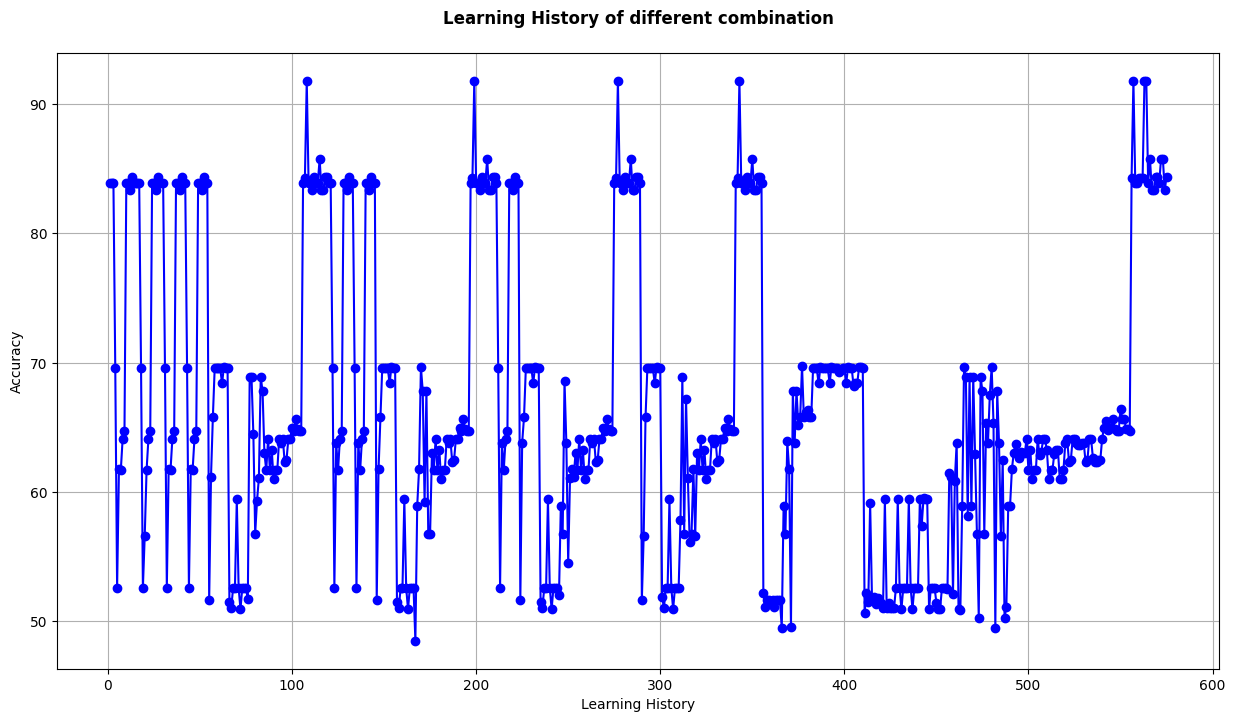




----------------------------------------------------------------------------------------------------------


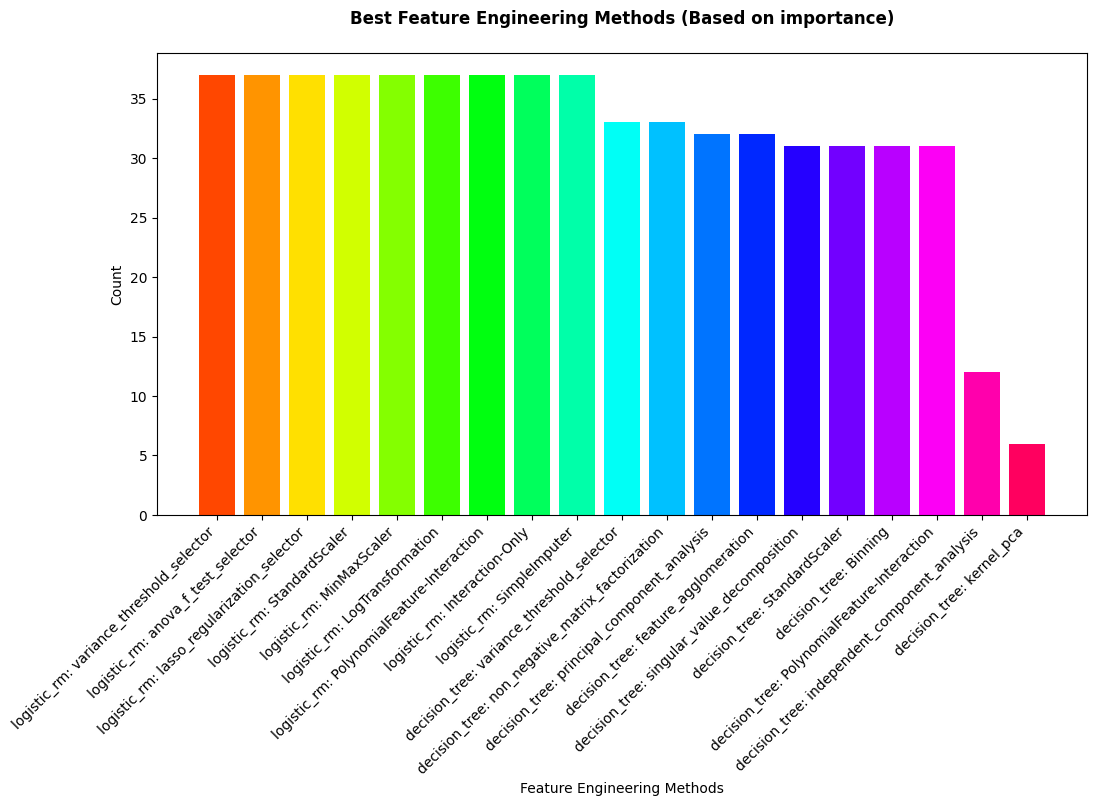




----------------------------------------------------------------------------------------------------------


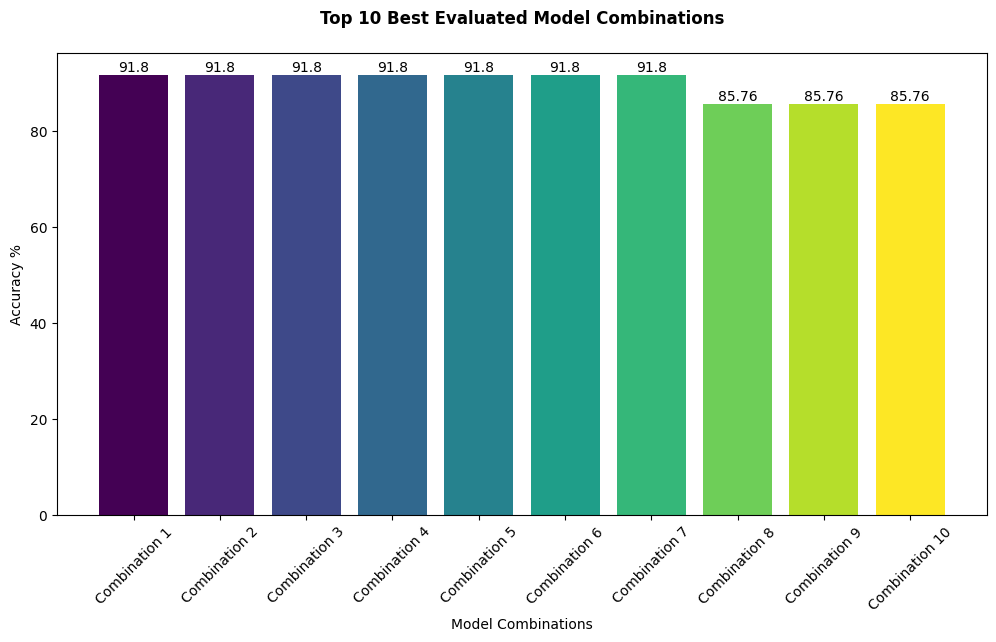

In [44]:
plot_learning_history(agent.learning_history, agent.learning_history.values())
print("\n\n")
print("----------------------------------------------------------------------------------------------------------")

plot_best_feature_methods(bestFEMethods)
print("\n\n")
print("----------------------------------------------------------------------------------------------------------")


plot_combination_accuracies(agent)

## Prediction (Using SVM) on Heart disease dataset




In [45]:
# reading csv data,
# preprocessing (if required, convert any string values to int, filling the empty values or removing them)
# convert dataframe into array, as arrays are the required paramter.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/drive/MyDrive/FE project brayan/heart.csv') #Read the dataset
df = df.dropna()

#df.describe()

labels = df['target']
df = df.drop('target', axis=1)
data = df.to_numpy()
labels = labels.to_numpy()

# Here, specify the problem_type during initialization if it's known and constant
PROBLEM = "Prediction2"

# Assuming you have already created and run the agent
agent = MLAgent(problem_type=PROBLEM, data=data, labels=labels)
agent.run(epochs=1)

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method VarianceThresholdSelector not recognized or not implemented.
ERROR:__main__:Method LassoRegularizationSelector not recognized or not implemented.
ERROR:__main__:Method PrincipalComponentAnalysis not recognized or not implemented.
ERROR:__main__:Method KernelPCA not recognized or not implemented.
ERROR:__main__:Method IndependentComponentAnalysis not recognized or not implemented.
ERROR:__main__:Method SingularValueDecomposition not recognized or not implemented.
ERROR:__main__:Method NonNegativeMatrixFactorization not recognized or not implemented.
ERROR:__main__:Method FeatureAgglomeration not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method VarianceThresholdSelector not recognized or not implemented.




Selected algorithm: SVM

Total combination 231
shape of the input data is:  (820, 13)
Random combinations (231) :  [['StandardScaler'], ['MinMaxScaler'], ['LogTransformation'], ['VarianceThresholdSelector'], ['LassoRegularizationSelector'], ['PrincipalComponentAnalysis'], ['KernelPCA'], ['IndependentComponentAnalysis'], ['SingularValueDecomposition'], ['NonNegativeMatrixFactorization'], ['FeatureAgglomeration'], ['StandardScaler', 'MinMaxScaler'], ['StandardScaler', 'LogTransformation'], ['StandardScaler', 'VarianceThresholdSelector'], ['StandardScaler', 'LassoRegularizationSelector'], ['StandardScaler', 'PrincipalComponentAnalysis'], ['StandardScaler', 'KernelPCA'], ['StandardScaler', 'IndependentComponentAnalysis'], ['StandardScaler', 'SingularValueDecomposition'], ['StandardScaler', 'NonNegativeMatrixFactorization'], ['StandardScaler', 'FeatureAgglomeration'], ['MinMaxScaler', 'LogTransformation'], ['MinMaxScaler', 'VarianceThresholdSelector'], ['MinMaxScaler', 'LassoRegularizatio

ERROR:__main__:Method LassoRegularizationSelector not recognized or not implemented.
ERROR:__main__:Method PrincipalComponentAnalysis not recognized or not implemented.
ERROR:__main__:Method KernelPCA not recognized or not implemented.
ERROR:__main__:Method IndependentComponentAnalysis not recognized or not implemented.
ERROR:__main__:Method SingularValueDecomposition not recognized or not implemented.
ERROR:__main__:Method NonNegativeMatrixFactorization not recognized or not implemented.
ERROR:__main__:Method FeatureAgglomeration not recognized or not implemented.


Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
========================== Random combination 16:['StandardScaler', 'PrincipalComponentAnalysis'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - 

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method VarianceThresholdSelector not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method LassoRegularizationSelector not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method PrincipalComponentAnalysis not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method KernelPCA not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method IndependentComponentAnalysis not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScale

========================== Random combination 22:['MinMaxScaler', 'LogTransformation'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
========================== Random combination 23:['MinMaxScaler', 'VarianceThresholdSelector'] =================

ERROR:__main__:Method SingularValueDecomposition not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method NonNegativeMatrixFactorization not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method FeatureAgglomeration not recognized or not implemented.
ERROR:__main__:Method VarianceThresholdSelector not recognized or not implemented.
ERROR:__main__:Method LassoRegularizationSelector not recognized or not implemented.
ERROR:__main__:Method PrincipalComponentAnalysis not recognized or not implemented.
ERROR:__main__:Method KernelPCA not recognized or not implemented.
ERROR:__main__:Method IndependentComponentAnalysis not recognized or not implemented.
ERROR:__main__:Method SingularValueDecomposition not recognized or not implemented.
ERROR:__main__:Method NonNegativeMatrixFactorization not recognized or not implem

Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
========================== Random combination 74:['StandardScaler', 'MinMaxScaler', 'NonNegativeMatrixFactorization'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after fe

ERROR:__main__:Method FeatureAgglomeration not recognized or not implemented.
ERROR:__main__:Method KernelPCA not recognized or not implemented.
ERROR:__main__:Method IndependentComponentAnalysis not recognized or not implemented.
ERROR:__main__:Method KernelPCA not recognized or not implemented.
ERROR:__main__:Method SingularValueDecomposition not recognized or not implemented.
ERROR:__main__:Method KernelPCA not recognized or not implemented.
ERROR:__main__:Method NonNegativeMatrixFactorization not recognized or not implemented.
ERROR:__main__:Method KernelPCA not recognized or not implemented.
ERROR:__main__:Method FeatureAgglomeration not recognized or not implemented.
ERROR:__main__:Method IndependentComponentAnalysis not recognized or not implemented.
ERROR:__main__:Method SingularValueDecomposition not recognized or not implemented.
ERROR:__main__:Method IndependentComponentAnalysis not recognized or not implemented.
ERROR:__main__:Method NonNegativeMatrixFactorization not recog

Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
========================== Random combination 102:['StandardScaler', 'KernelPCA', 'IndependentComponentAnalysis'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape of the data now is:  (820, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after featur

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method KernelPCA not recognized or not implemented.
ERROR:__main__:Method FeatureAgglomeration not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method IndependentComponentAnalysis not recognized or not implemented.
ERROR:__main__:Method SingularValueDecomposition not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method IndependentComponentAnalysis not recognized or not implemented.
ERROR:__main__:Method NonNegativeMatrixFactorization not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method IndependentComponentAnalysis not recognized or not implemented.
ERROR:__main__:Method FeatureAgglomeration not recognized or not 

Shape after feature engineering - Train: (820, 13) Test: (205, 13)
========================== Random combination 141:['MinMaxScaler', 'KernelPCA', 'FeatureAgglomeration'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
========================== Random combination 142:['MinMaxScaler'

ERROR:__main__:Method IndependentComponentAnalysis not recognized or not implemented.
ERROR:__main__:Method VarianceThresholdSelector not recognized or not implemented.
ERROR:__main__:Method KernelPCA not recognized or not implemented.
ERROR:__main__:Method SingularValueDecomposition not recognized or not implemented.
ERROR:__main__:Method VarianceThresholdSelector not recognized or not implemented.
ERROR:__main__:Method KernelPCA not recognized or not implemented.
ERROR:__main__:Method NonNegativeMatrixFactorization not recognized or not implemented.
ERROR:__main__:Method VarianceThresholdSelector not recognized or not implemented.
ERROR:__main__:Method KernelPCA not recognized or not implemented.
ERROR:__main__:Method FeatureAgglomeration not recognized or not implemented.
ERROR:__main__:Method VarianceThresholdSelector not recognized or not implemented.
ERROR:__main__:Method IndependentComponentAnalysis not recognized or not implemented.
ERROR:__main__:Method SingularValueDecomposit

Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
========================== Random combination 188:['VarianceThresholdSelector', 'KernelPCA', 'SingularValueDecomposition'] ==========================
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820, 13) Test: (205, 13)
Shape after feature engineering - Train: (820,

(('S', 't', 'a', 'n', 'd', 'a', 'r', 'd', 'S', 'c', 'a', 'l', 'e', 'r'),)

In [46]:
agent.print_top_model_combinations(top_n=10)
print("=================================================================================================================================")
print_best_feature_methods(bestFEMethods)

Best Tob Combinations 10
Combination 1: StandardScaler - Accuracy: 84.29%
Combination 2: StandardScaler, MinMaxScaler - Accuracy: 84.29%
Combination 3: StandardScaler, VarianceThresholdSelector - Accuracy: 84.29%
Combination 4: StandardScaler, LassoRegularizationSelector - Accuracy: 84.29%
Combination 5: StandardScaler, PrincipalComponentAnalysis - Accuracy: 84.29%
Combination 6: StandardScaler, KernelPCA - Accuracy: 84.29%
Combination 7: StandardScaler, IndependentComponentAnalysis - Accuracy: 84.29%
Combination 8: StandardScaler, SingularValueDecomposition - Accuracy: 84.29%
Combination 9: StandardScaler, NonNegativeMatrixFactorization - Accuracy: 84.29%
Combination 10: StandardScaler, FeatureAgglomeration - Accuracy: 84.29%
Best feature methods (Based on Importance):
('SVM', 'StandardScaler'): 56
('SVM', 'MinMaxScaler'): 56
('SVM', 'LogTransformation'): 56
('SVM', 'VarianceThresholdSelector'): 56
('SVM', 'LassoRegularizationSelector'): 56
('SVM', 'PrincipalComponentAnalysis'): 56
('

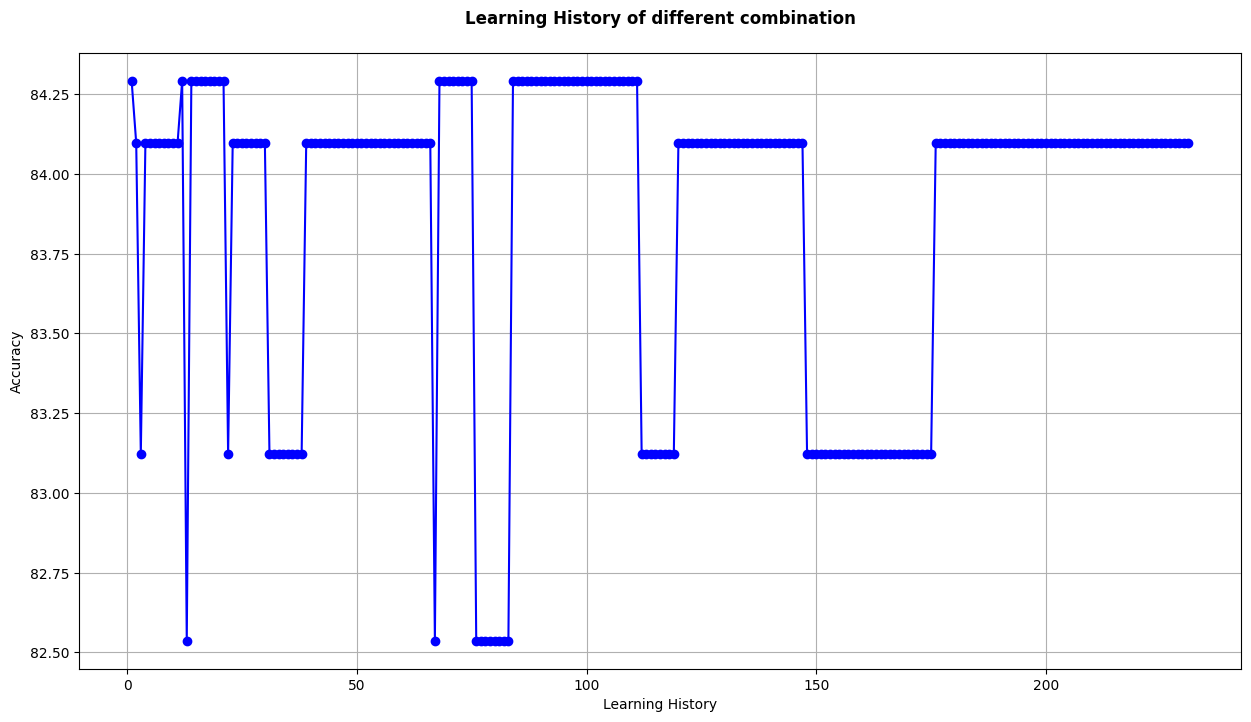




----------------------------------------------------------------------------------------------------------


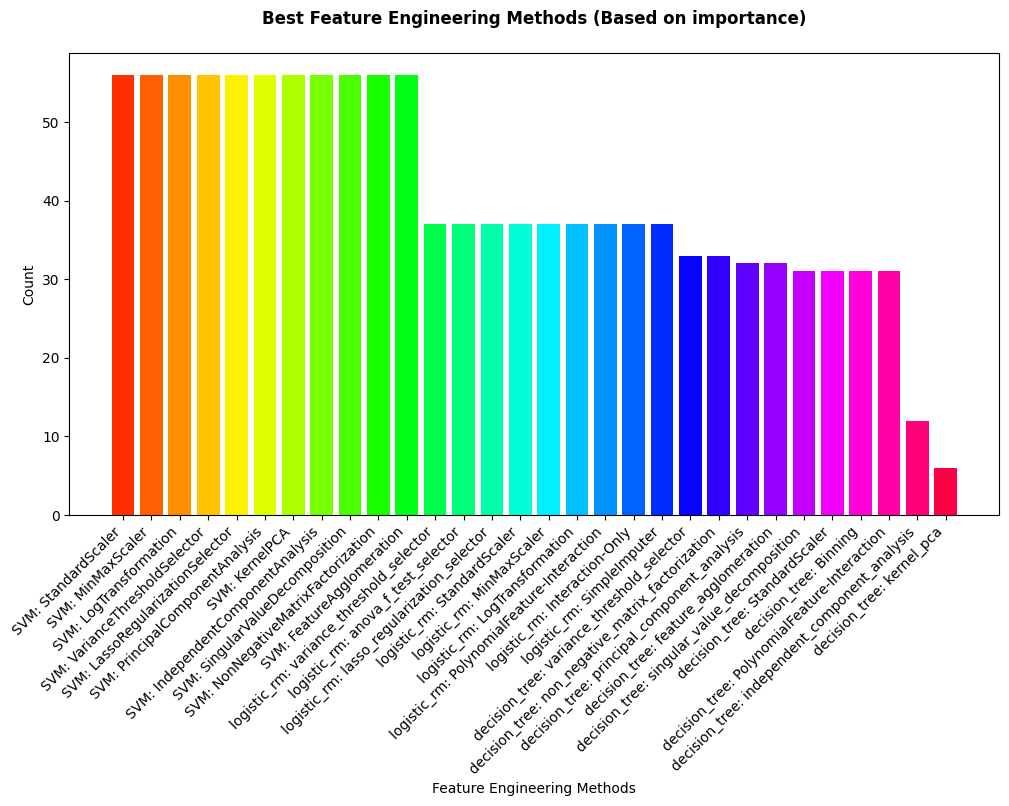




----------------------------------------------------------------------------------------------------------


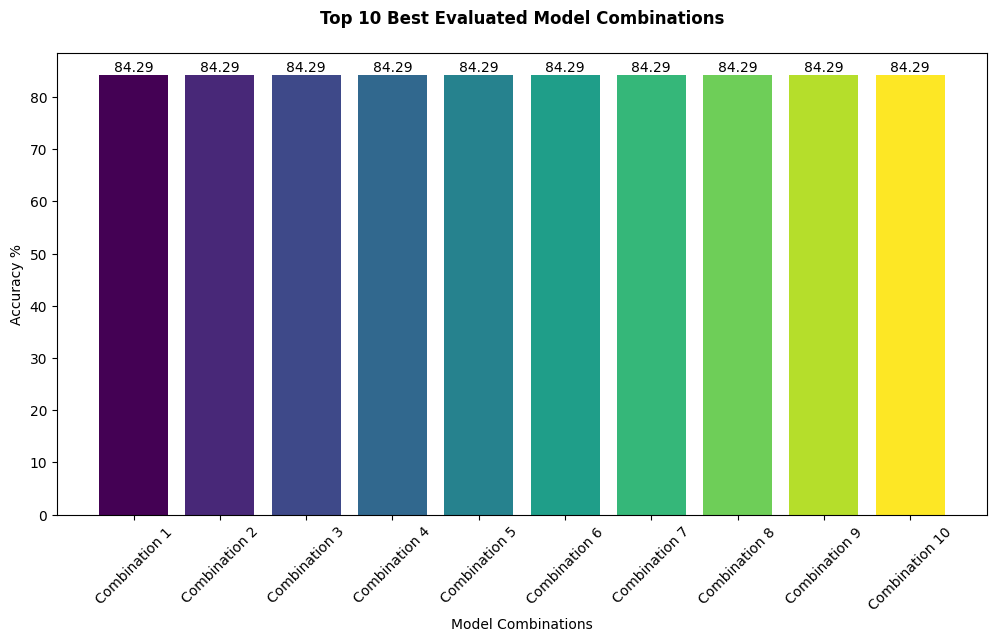

In [47]:
plot_learning_history(agent.learning_history, agent.learning_history.values())
print("\n\n")
print("----------------------------------------------------------------------------------------------------------")

plot_best_feature_methods(bestFEMethods)
print("\n\n")
print("----------------------------------------------------------------------------------------------------------")


plot_combination_accuracies(agent)

### Image classification (CNN) on IRIS dataset

In [48]:
# Usage
iris = datasets.load_iris()
data, labels = iris.data, iris.target

PROBLEM = "Image Classification"

agent = MLAgent(problem_type=PROBLEM, data=data, labels=labels)
agent.run(epochs=1)

ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'




Selected algorithm: CNN

Total combination 377
shape of the input data is:  (120, 4)
Random combinations (377) :  [['recursive_feature_elimination'], ['principal_component_analysis'], ['kernel_pca'], ['independent_component_analysis'], ['non_negative_matrix_factorization'], ['singular_value_decomposition'], ['feature_agglomeration'], ['standard_scaling'], ['MinMaxScaler'], ['SimpleImputer'], ['normalization'], ['image_augmentation'], ['histogram_equalization'], ['recursive_feature_elimination', 'principal_component_analysis'], ['recursive_feature_elimination', 'kernel_pca'], ['recursive_feature_elimination', 'independent_component_analysis'], ['recursive_feature_elimination', 'non_negative_matrix_factorization'], ['recursive_feature_elimination', 'singular_value_decomposition'], ['recursive_feature_elimination', 'feature_agglomeration'], ['recursive_feature_elimination', 'standard_scaling'], ['recursive_feature_elimination', 'MinMaxScaler'], ['recursive_feature_elimination', 'SimpleI

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anony

(120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 5:['non_negative_matrix_factorization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30,

ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method recursive_feature_elimination failed: 

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 18:['recursive_feature_elimination', 'singular_value_decomposition'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method image_a

========================== Random combination 37:['kernel_pca', 'independent_component_analysis'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - T

ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by d

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 47:['independent_component_analysis', 'non_negative_matrix_factorization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method image_augmentation fai

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 53:['independent_component_analysis', 'normalization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shap

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
>

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 56:['non_negative_matrix_factorization', 'singular_value_decomposition'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) 

ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1

ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 's

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 61:['non_negative_matrix_factorization', 'normalization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
S

ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1

ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 's

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 68:['singular_value_decomposition', 'normalization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape 

ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1

ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method standard_scaling not recognized or not impl

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 75:['feature_agglomeration', 'image_augmentation'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Tr

ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method recursive_feature_elimination failed: 

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 95:['recursive_feature_elimination', 'principal_component_analysis', 'singular_value_decomposition'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) 

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 105:['recursive_feature_elimination', 'kernel_pca', 'singular_value_decomposition'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Sha

ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__ma

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 114:['recursive_feature_elimination', 'independent_component_analysis', 'singular_value_decomposition'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data n

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
/usr/local/lib/python3.

Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 117:['recursive_feature_elimination', 'independent_component_analysis', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape o

ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method image_augmentation failed: 'Pipeline' 

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 124:['recursive_feature_elimination', 'non_negative_matrix_factorization', 'standard_scaling'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: 

ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1

ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method recursive_feature_elimina

Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 129:['recursive_feature_elimination', 'non_negative_matrix_factorization', 'histogram_equalization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature en

ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 135:['recursive_feature_elimination', 'singular_value_decomposition', 'image_augmentation'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30

ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1

ERROR:__main__:Method recursive_feature_elimination failed: recursive_feature_elimination() missing 1 required positional argument: 'target'
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/im

Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
========================== Random combination 157:['recursive_feature_elimination', 'image_augmentation', 'histogram_equalization'] ==========================
Shape after feature engineering - Tra

ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' 

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 162:['principal_component_analysis', 'kernel_pca', 'standard_scaling'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the dat

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Startin

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 169:['principal_component_analysis', 'independent_component_analysis', 'singular_value_decomposition'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after 

ERROR:__main__:Method standard_scaling not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 172:['principal_component_analysis', 'independent_component_analysis', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Tr

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 173:['principal_component_analysis', 'independent_component_analysis', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 175:['principal_component_analysis', 'independent_component_analysis', 'image_augmentation'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature en

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1



Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 180:['principal_component_analysis', 'non_negative_matrix_factorization', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 

ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' 

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 187:['principal_component_analysis', 'singular_value_decomposition', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Sh

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1

ERROR:__main__:Method standard_scaling not recognized or not impleme

 (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 194:['principal_component_analysis', 'feature_agglomeration', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - 

ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1

ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemente

Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 206:['principal_component_analysis', 'MinMaxScaler', 'histogram_equalization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (12

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method standard_scaling not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/s

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 216:['kernel_pca', 'independent_component_analysis', 'standard_scaling'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 221:['kernel_pca', 'independent_component_analysis', 'histogram_equalization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape af

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method standard_scaling not recognized or not implemented.


Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 225:['kernel_pca', 'non_negative_matrix_factorization', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after fea

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665:

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 226:['kernel_pca', 'non_negative_matrix_factorization', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after fe

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 229:['kernel_pca', 'non_negative_matrix_factorization', 'histogram_equalization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape

ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1

ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 's

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 234:['kernel_pca', 'singular_value_decomposition', 'normalization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature

ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'


 (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 240:['kernel_pca', 'feature_agglomeration', 'normalization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after featu

ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1

ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Metho

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 243:['kernel_pca', 'standard_scaling', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering 

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 250:['kernel_pca', 'MinMaxScaler', 'image_augmentation'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineerin

ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1

ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePoli

Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 256:['kernel_pca', 'normalization', 'histogram_equalization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engin

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-varian

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 262:['independent_component_analysis', 'non_negative_matrix_factorization', 'SimpleImputer'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (12

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method standard_scaling not recognized or not implemented.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/s

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 268:['independent_component_analysis', 'singular_value_decomposition', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or 

========================== Random combination 279:['independent_component_analysis', 'standard_scaling', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2

ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' 

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 295:['non_negative_matrix_factorization', 'singular_value_decomposition', 'standard_scaling'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature e

ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' 

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 302:['non_negative_matrix_factorization', 'feature_agglomeration', 'MinMaxScaler'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shap

ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
ERROR:__main__:Method standard_scaling not recognized or not implemented.
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::O

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 309:['non_negative_matrix_factorization', 'standard_scaling', 'normalization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (12

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'


Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 313:['non_negative_matrix_factorization', 'MinMaxScaler', 'normalization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'


Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 315:['non_negative_matrix_factorization', 'MinMaxScaler', 'histogram_equalization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train

ERROR:__main__:Method MinMaxScaler failed: 'MinMaxScaler' object has no attribute 'shape'
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1

ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_imag

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 316:['non_negative_matrix_factorization', 'SimpleImputer', 'normalization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 

ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1

ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePoli

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 321:['non_negative_matrix_factorization', 'image_augmentation', 'histogram_equalization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 

ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'augment_image'
ERROR:__main__:Method SimpleImputer not recognized or not implemented.
ERROR:__main__:Method histogram_equalization failed: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1

ERROR:__main__:Method image_augmentation failed: 'Pipeline' object has no attribute 'au

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 5ms/step - loss: 0.7682 - accuracy: 0.8000
Epoch 9/10
4/4 [==============================] - 0s 5ms/step - loss: 0.7328 - accuracy: 0.8083
Epoch 10/10
4/4 [==============================] - 0s 5ms/step - loss: 0.6996 - accuracy: 0.7333
Epoch 1, Model # 150, accuracy = 76.6667, Combination ['recursive_feature_elimination', 'MinMaxScaler', 'image_augmentation']
Training start
Epoch 1/10
4/4 [==============================] - 1s 6ms/step - loss: 1.4536 - accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 0s 5ms/step - loss: 1.2136 - accuracy: 0.3250
Epoch 3/10
4/4 [==============================] - 0s 5ms/step - loss: 1.1157 - accuracy: 0.2917
Epoch 4/10
4/4 [==============================] - 0s 6ms/step - loss: 1.0664 - accuracy: 0.3417
Epoch 5/10
4/4 [==============================] - 0s 5ms/step - loss: 1.0052 - accuracy: 0.3417
Epoch 6/10
4/4 [==============================

(('r',
  'e',
  'c',
  'u',
  'r',
  's',
  'i',
  'v',
  'e',
  '_',
  'f',
  'e',
  'a',
  't',
  'u',
  'r',
  'e',
  '_',
  'e',
  'l',
  'i',
  'm',
  'i',
  'n',
  'a',
  't',
  'i',
  'o',
  'n'),
 ('S', 'i', 'm', 'p', 'l', 'e', 'I', 'm', 'p', 'u', 't', 'e', 'r'))

In [49]:
agent.print_top_model_combinations(top_n=10)
print("=================================================================================================================================")
print_best_feature_methods(bestFEMethods)

Best Tob Combinations 10
Combination 1: recursive_feature_elimination, SimpleImputer - Accuracy: 93.33%
Combination 2: recursive_feature_elimination, singular_value_decomposition, SimpleImputer - Accuracy: 93.33%
Combination 3: singular_value_decomposition, standard_scaling, histogram_equalization - Accuracy: 93.33%
Combination 4: singular_value_decomposition, MinMaxScaler, histogram_equalization - Accuracy: 93.33%
Combination 5: standard_scaling - Accuracy: 90.00%
Combination 6: singular_value_decomposition, image_augmentation - Accuracy: 90.00%
Combination 7: SimpleImputer, histogram_equalization - Accuracy: 90.00%
Combination 8: singular_value_decomposition, feature_agglomeration, histogram_equalization - Accuracy: 90.00%
Combination 9: singular_value_decomposition, standard_scaling, SimpleImputer - Accuracy: 90.00%
Combination 10: singular_value_decomposition, MinMaxScaler, image_augmentation - Accuracy: 90.00%
Best feature methods (Based on Importance):
('SVM', 'StandardScaler'): 

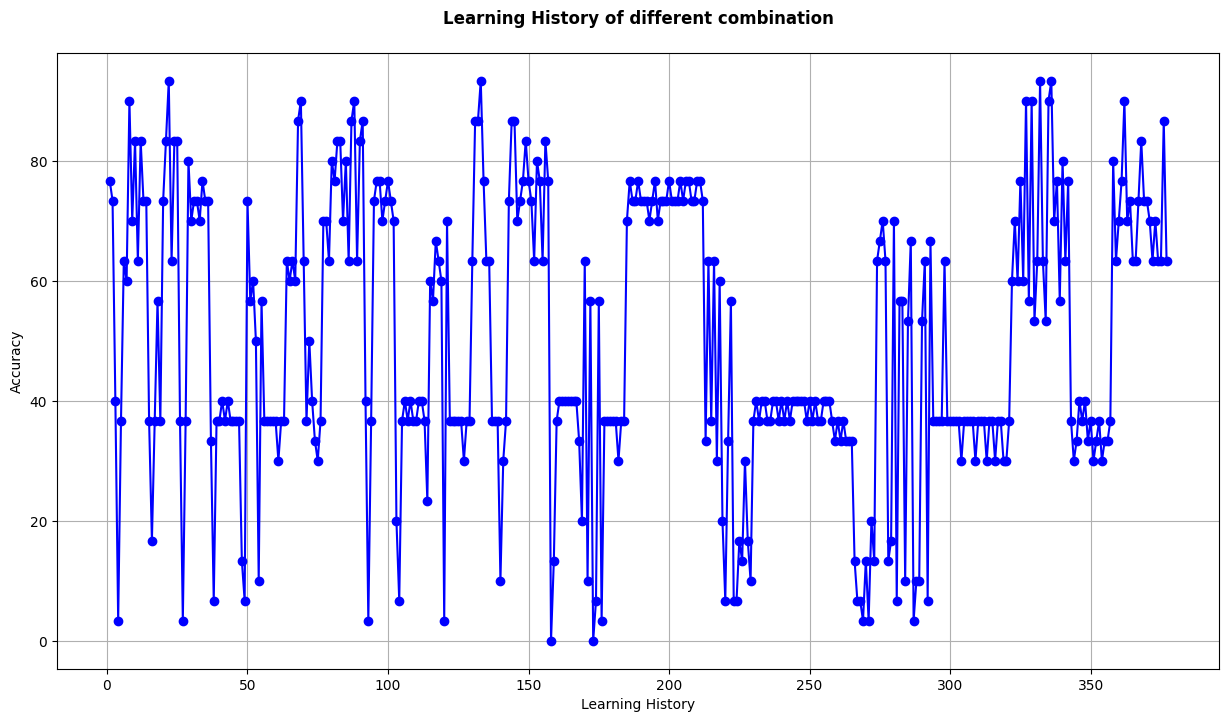




----------------------------------------------------------------------------------------------------------


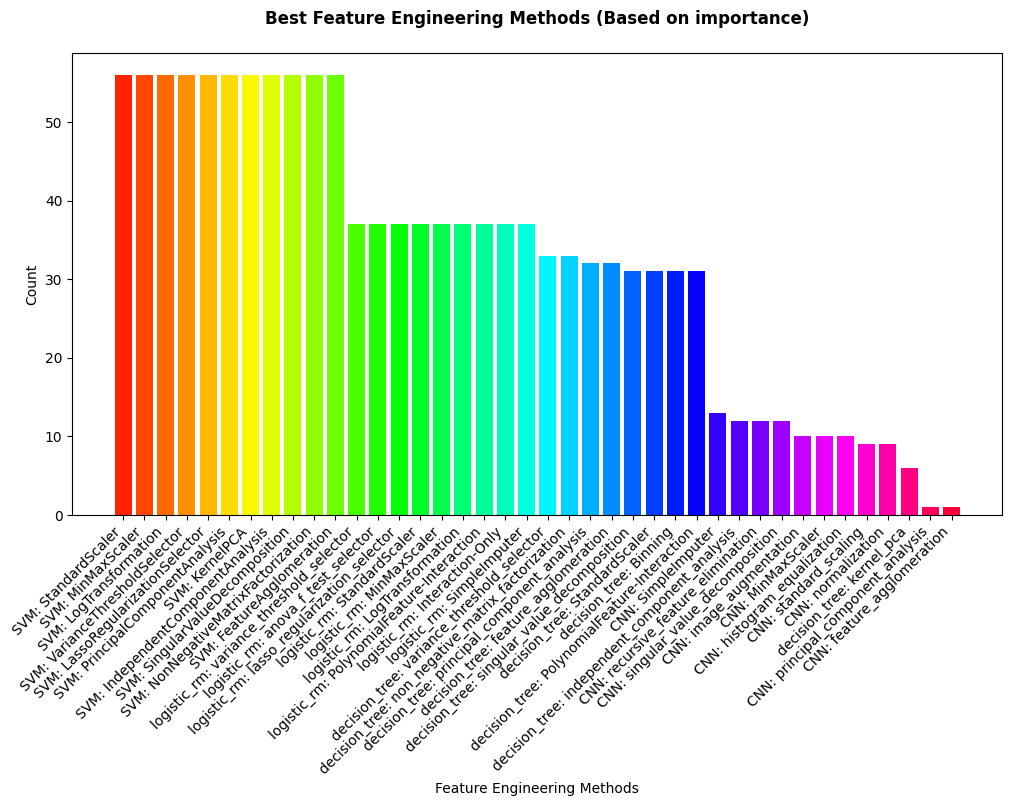




----------------------------------------------------------------------------------------------------------


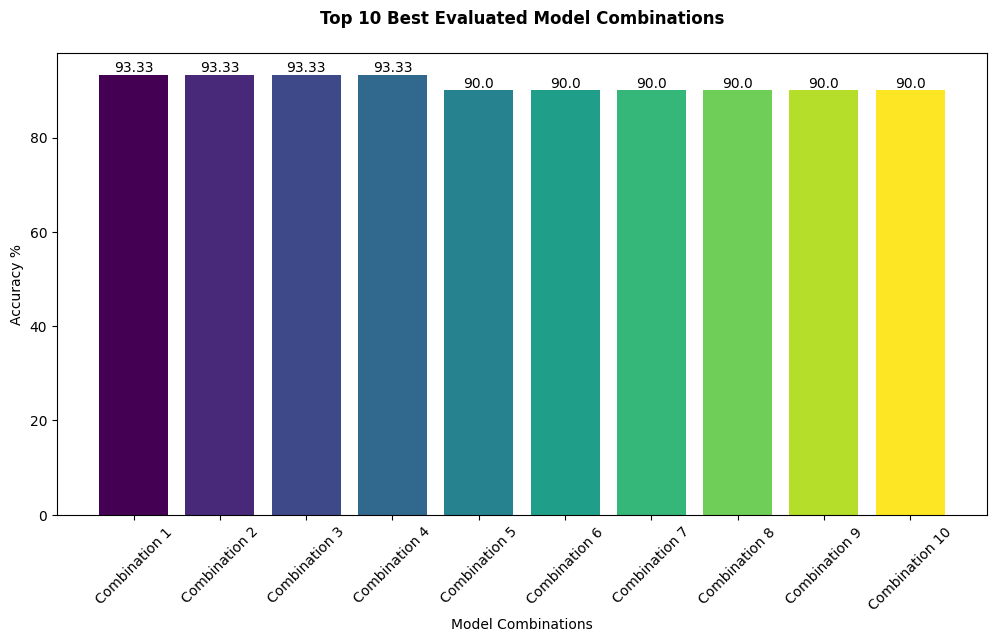

In [50]:
plot_learning_history(agent.learning_history, agent.learning_history.values())
print("\n\n")
print("----------------------------------------------------------------------------------------------------------")

plot_best_feature_methods(bestFEMethods)
print("\n\n")
print("----------------------------------------------------------------------------------------------------------")


plot_combination_accuracies(agent)